# Transformer Model

In [1]:
# Model imports
import torch
import torch.nn as nn
import math

### Input Embedder

In [2]:
# Input embedder class
class InputEmbedder(nn.Module):

    # Constructor
    def __init__(self, d_model:int, vocab_size:int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    # Forward function 
    def forward(self, x):
        out = self.embedding(x) * math.sqrt(self.d_model) # The original paper multiples embeddings by sqrt of d_model
        return out

### Positional Encoder

In [3]:
# Positional encoder class
class PositionalEncoder(nn.Module):

    # Constructor
    def __init__(self, d_model:int, seq_length:int, dropout:float):

        # Initialize properties
        super().__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.dropout = nn.Dropout(dropout)

        # PE matrix - (seq_length, d_model)
        pe = torch.zeros(seq_length, d_model)
        
        # Positions vector for numerator of PE matrix formula - (seq_length, 1)
        num_term = torch.arange(0, seq_length, dtype=torch.float32).unsqueeze(1)
        
        # Denominator of sin/cos arg - Value of 10000^(2i/d_model) for i ranging from 0 to d_model/2 - (d_model/2)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000) / d_model))
        
        # Apply sin/cos functions
        trig_arg = num_term * div_term
        pe[:,0::2] = torch.sin(trig_arg)
        pe[:,1::2] = torch.cos(trig_arg)

        # Add batch dimension to make it (1,seq_len,d_model)
        pe = pe.unsqueeze(0)

        # Register buffer
        self.register_buffer('pe', pe)

    # Forward function
    def forward(self, x):
        x = x + (self.pe[:,:x.shape[1],:]).requires_grad_(False)
        return self.dropout(x)

**Testing**

In [4]:
seq_length = 100
num = torch.arange(0, seq_length, dtype=torch.float32).unsqueeze(1)
num.shape

torch.Size([100, 1])

In [5]:
d_model = 512
den = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000) / d_model))
den.shape

torch.Size([256])

In [6]:
pe = torch.zeros(seq_length, d_model)
pe.shape

torch.Size([100, 512])

In [7]:
(num*den).shape

torch.Size([100, 256])

### Layer Normalization

In [8]:
# Layer normalization module
class LayerNormalization(nn.Module):

    # Constructor
    def __init__(self, eps: float = 1e-5):

        # Init
        super().__init__()
        self.eps = eps # This is required for numerical stability and avoid div by zero
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    # Forward method
    def forward(self, x):

        # Calculate mean and std within each sample
        mean = x.mean(dim=-1, keepdim=True) # x is of shape (batch, seq_length, d_model), mean is (batch, seq_length, 1)
        std = x.std(dim=-1, keepdim=True) # std is (batch, seq_length, 1)

        # Normalize and return
        return self.alpha * ((x - mean) / (std + self.eps)) + self.bias # Broadcasting will make the return value of shape (batch, seq_length, d_model)

**Testing**

In [9]:
x = torch.rand(4, 100, 512)
x.shape

torch.Size([4, 100, 512])

In [10]:
x.mean(dim=-1).shape

torch.Size([4, 100])

In [11]:
x.mean(dim=-1, keepdim=True).shape

torch.Size([4, 100, 1])

In [12]:
(x - x.mean(dim=-1, keepdim=True)).shape

torch.Size([4, 100, 512])

### Feed Forward Block

In [13]:
# Feed forward layer module
class FeedForwardBlock(nn.Module):

    # Constructor
    def __init__(self, d_model: int, d_ff: int, dropout: float):

        # Init
        super().__init__()

        # Layers
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.linear_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    # Forward method
    def forward(self, x):
        
        # Pass x (batch, seq_length, d_model) through the network
        out = torch.relu(self.linear_1(x))
        out = self.dropout(out)
        out = self.linear_2(out)

        # Return output
        return out

### Multi-Head Attention Block

In [14]:
# Multi head attention block
class MultiHeadAttentionBlock(nn.Module):

    # Constructor
    def __init__(self, d_model: int, h: int, dropout: float):

        # Init
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model should be divisible by h"
        self.d_k = d_model // h

        # Setup weight matrices using linear layer
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    # Split heads
    def split_heads(self, x):
        # (batch, seq_len, d_model) => (batch, seq_len, h, d_k) => (batch, h, seq_len, d_k)
        # Each head will now get (seq_len, d_k), i.e. full sequence but partial embeddings
        batch_size, seq_length, d_model = x.shape
        return x.view(batch_size, seq_length, self.h, self.d_k).transpose(1,2)

    # Combine heads
    def combine_heads(self, x):
        batch_size, h, seq_length, d_k = x.shape
        # Revert transpose: (batch, h, seq_len, d_k) => (batch, seq_len, h, d_k)
        x = x.transpose(1, 2)
        # Combine h and d_k
        return x.contiguous().view(batch_size, -1, self.d_model)

    # Attention function
    def calculate_attention(self, query, key, value, mask = None):

        # Calculate scores: (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(self.d_k) # Transpose the (seq_len, dk) part for keys to get (seq_len, seq_len) scores - embeddings (in each head) of each word dotted with every other word  

        # Apply mask
        if mask is not None:
            attention_scores.masked_fill_(mask==0, -1e9)

        # Softmax - dims stay (batch, h, seq_len, seq_len)
        attention_scores = attention_scores.softmax(dim=-1) # Last dim (-1) is the weight of each V for the Q in second last dim (-2)

        # Dropout
        attention_scores = self.dropout(attention_scores)

        # Generate output and return
        output = attention_scores @ value # (batch, h, seq_len, d_k) - seq_len, d_k is formed by take weighted sum of value according to attn scores
        return output, attention_scores
    
    # Forward method
    def forward(self, q, k, v, mask):

        # Generate Q', K' and V'. Dims for all of them remain same (batch, seq_len, d_model) => (batch, seq_len, d_model)
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # Split heads. New dim: (batch, h, seq_len, d_k)
        query = self.split_heads(query)
        key = self.split_heads(key)
        value = self.split_heads(value)

        # Calculate attention scores
        output, attention_scores = self.calculate_attention(query, key, value, mask)

        # Combine heads. New dim: (batch, seq_len, d_model)
        output = self.combine_heads(output)

        # Multiply by output weight matrix and return
        return self.w_o(output) # (batch, seq_len, d_model)

**Testing**

In [15]:
x = torch.rand(4,100,512)
x.shape

torch.Size([4, 100, 512])

In [16]:
x = x.view(4,100,8,64)
x = x.transpose(1, 2)
x.shape

torch.Size([4, 8, 100, 64])

In [17]:
attn_score = (x @ x.transpose(-1,-2)) # Using x instead of Q,K of same dims
attn_score.shape

torch.Size([4, 8, 100, 100])

In [18]:
x = (attn_score @ x)
x.shape

torch.Size([4, 8, 100, 64])

In [19]:
x = x.transpose(1, 2)
x = x.contiguous().view(4,-1,512)
x.shape

torch.Size([4, 100, 512])

### Residual Connection Block

In [20]:
# Residual connection block
class ResidualConnectionBlock(nn.Module):

    # Constructor
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    # Forward method
    def forward(self, x, sublayer):

        # Apply norm, dropout, add and return
        return x + self.dropout(sublayer(self.norm(x))) # Applying norm first is different from paper. It improves convergence and removes need of warmig up

### Encoder Block

In [21]:
# Encoder block
class EncoderBlock(nn.Module):

    # Constructor
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnectionBlock(dropout) for _ in range(2)])

    # Forward method
    def forward(self, x, src_mask):

        # Apply multi head attention
        x = self.residual_connections[0](x, lambda x:self.self_attention_block(x, x, x, src_mask))

        # Apply feed forward network
        x = self.residual_connections[1](x, self.feed_forward_block)

        # Return output
        return x

### Encoder

In [22]:
# Encoder layer of the transformer model
class Encoder(nn.Module):

    # Constructor
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    # Forward method
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

### Decoder Block

In [23]:
# Decoder block
class DecoderBlock(nn.Module):

    # Constructor
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block:FeedForwardBlock, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnectionBlock(dropout) for _ in range(3)])

    # Forward method
    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Apply self attention
        x = self.residual_connections[0](x, lambda x:self.self_attention_block(x, x, x, tgt_mask))

        # Apply cross attention
        x = self.residual_connections[1](x, lambda x:self.self_attention_block(x, encoder_output, encoder_output, src_mask))

        # Apply feed forward network
        x = self.residual_connections[2](x, self.feed_forward_block)

        # Return output
        return x

### Decoder

In [24]:
# Decoder layer of the transformer model
class Decoder(nn.Module):

    # Constructor
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    # Forward method
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

### Output Linear Layer

In [25]:
# Linear layer to get output of transformer model
class OutputLinearLayer(nn.Module):

    # Constructor
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.linear = nn.Linear(d_model, vocab_size)

    # Forward method
    def forward(self, x):
        return torch.log_softmax(self.linear(x), dim=-1)

### Transformer Model

In [26]:
# Transformer model
class TransformerModel(nn.Module):

    # Constructor
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embedding: InputEmbedder, tgt_embedding: InputEmbedder, src_pos: PositionalEncoder, tgt_pos: PositionalEncoder, output_layer: OutputLinearLayer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embedding = src_embedding
        self.tgt_embedding = tgt_embedding
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.output_layer = output_layer

    # Encode method
    def encode(self, src, src_mask):
        src = self.src_embedding(src)
        src = self.src_pos(src)
        src = self.encoder(src, src_mask)
        return src

    # Decode method
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embedding(tgt)
        tgt = self.tgt_pos(tgt)
        tgt = self.decoder(tgt, encoder_output, src_mask, tgt_mask)
        return tgt

    # Output projection method
    def project(self, x):
        return self.output_layer(x)

### Transformer Factory

In [27]:
# Function to build transformer model
def build_transformer_model(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> TransformerModel:

    # Create embedder layers
    src_embedding = InputEmbedder(d_model, src_vocab_size)
    tgt_embedding = InputEmbedder(d_model, tgt_vocab_size)

    # Positional encoder layers
    src_pos = PositionalEncoder(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoder(d_model, tgt_seq_len, dropout)

    # Encoder blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        encoder_ff = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(encoder_self_attn, encoder_ff, dropout)
        encoder_blocks.append(encoder_block)

    # Decoder blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_ff = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(decoder_self_attn, decoder_cross_attn, decoder_ff, dropout)
        decoder_blocks.append(decoder_block)

    # Encoder and decoder layers
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # Output layer
    output_layer = OutputLinearLayer(d_model, tgt_vocab_size)

    # Transformer model
    transformer = TransformerModel(encoder, decoder, src_embedding, tgt_embedding, src_pos, tgt_pos, output_layer)

    # Initialize model params - make training faster with xavier
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    # Return model
    return transformer

### Inference Decoder 

In [109]:
# Decoder function for inference
def inference_decode(model:TransformerModel, src, src_mask, tokenizer_src, tokenizer_tgt, max_len, device):

    # Special tokens for tgt sequence
    bos_idx = tokenizer_tgt.token_to_id(SPECIAL_TOKENS[BOS_IDX])
    eos_idx = tokenizer_tgt.token_to_id(SPECIAL_TOKENS[EOS_IDX])

    # Compute encoder outputs
    encoder_output = model.encode(src, src_mask)

    # Compute decoder input and output
    decoder_input = torch.empty(1,1).fill_(bos_idx).type_as(src).to(device)
    while True:

        # Break if we are at max length
        if(decoder_input.size(1) == max_len):
            break

        # Target mask
        decoder_mask = torch.triu(torch.ones((1, decoder_input.size(1), decoder_input.size(1))), diagonal=1).type_as(src).to(device)

        # Model output
        out = model.decode(encoder_output, src_mask, decoder_input, decoder_mask)

        # Get next token and add to output
        probs = model.project(out[:,-1])
        _, next_token = torch.max(probs, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1).type_as(src).fill_(next_token.item()).to(device)], dim=1)

        # Break if we generated EOS
        if next_token == eos_idx:
            break

    # Return output
    return decoder_input.squeeze(0)

# Dataset

In [29]:
!pip install -q matplotlib tokenizers datasets

In [30]:
# Imports
import torch
import torch.nn
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

### Constants

In [31]:
# Special tokens
UNK_IDX = 0
PAD_IDX = 1
BOS_IDX = 2
EOS_IDX = 3
SPECIAL_TOKENS = ['<UNK>', '<PAD>', '<BOS>', '<EOS>'] 

In [32]:
# Dataset config
dataset_name = 'bentrevett/multi30k'

### Dataset Class

In [33]:
# Dataset class
class LangTranslationDataset(Dataset):

    # Constructor
    def __init__(self, dataset, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        
        # Init values
        super().__init__()
        self.dataset = dataset
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.seq_len = seq_len

        # Set special tokens
        self.bos_token = torch.LongTensor([tokenizer_src.token_to_id(SPECIAL_TOKENS[BOS_IDX])])
        self.eos_token = torch.LongTensor([tokenizer_src.token_to_id(SPECIAL_TOKENS[EOS_IDX])])
        self.pad_token = torch.LongTensor([tokenizer_src.token_to_id(SPECIAL_TOKENS[PAD_IDX])])

    # Length function
    def __len__(self):
        return len(self.dataset)

    # Get item function
    def __getitem__(self, index):

        # Get the src and tgt sentences
        data_item = self.dataset[index]
        src_text = data_item[self.src_lang]
        tgt_text = data_item[self.tgt_lang]

        # Tokenize sentences
        src_tokens = self.tokenizer_src.encode(src_text).ids
        tgt_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Generate tensors (encoder input, decoder input, label) of length `seq_len` by adding padding, bos and eos tokens
        padding_tokens_count_src = self.seq_len - len(src_tokens) - 2 # BOS and EOS tokens: 2
        padding_tokens_count_tgt = self.seq_len - len(tgt_tokens) - 1 # EOS token is not required
        if (padding_tokens_count_src < 0 or padding_tokens_count_tgt < 0):
            raise Error('Sentence does not fit in `self.seq_len`')
        encoder_input = torch.cat([
            self.bos_token, 
            torch.tensor(src_tokens, dtype=torch.int64), 
            self.eos_token, 
            torch.full((padding_tokens_count_src,), self.pad_token.item(), dtype=torch.int64)
        ])
        decoder_input = torch.cat([
            self.bos_token, 
            torch.tensor(tgt_tokens, dtype=torch.int64), 
            torch.full((padding_tokens_count_tgt,), self.pad_token.item(), dtype=torch.int64)
        ])
        label = torch.cat([
            torch.tensor(tgt_tokens, dtype=torch.int64), 
            self.eos_token,
            torch.full((padding_tokens_count_tgt,), self.pad_token.item(), dtype=torch.int64)
        ])

        # Assert lengths
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        # Generate masks
        encoder_mask = (encoder_input != self.pad_token.item()).unsqueeze(0).unsqueeze(0).int()  # (1, 1, seq_len): (batch dim, seq dim, mask data)
        decoder_causal_mask = torch.triu(torch.ones(1, self.seq_len, self.seq_len), diagonal=1).type(torch.int) == 0
        decoder_mask = (decoder_input != self.pad_token.item()).unsqueeze(0).unsqueeze(0).int() & decoder_causal_mask  # (1, 1, seq_len) & (1, seq_len, seq_len) = (1, seq_len, seq_len)
        
        # Return tensors
        return {
            'src_text': src_text,
            'tgt_text': tgt_text,
            'encoder_input': encoder_input,  # (seq_len)
            'decoder_input': decoder_input,  # (seq_len)
            'encoder_mask': encoder_mask,    # (1, 1, seq_len)
            'decoder_mask': decoder_mask,    # (1, seq_len, seq_len)
            'label': label                   # (seq_len)
        }

### Dataset & Tokenizer Utils

**Testing**

In [79]:
# Load dataset
dataset_raw = load_dataset(dataset_name)
dataset_raw

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [80]:
# Build tokenizers
tokenizer_src = build_tokenizer(None, dataset_raw['train'], 'en')
tokenizer_tgt = build_tokenizer(None, dataset_raw['train'], 'de')

In [81]:
# Test src tokenizer
src_enc = tokenizer_src.encode('Several men in hard hats are operating a giant pulley system.')
print(src_enc.tokens)
print(src_enc.ids)

['Several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']
[165, 36, 7, 336, 288, 17, 1224, 4, 758, 4506, 2959, 5]


In [82]:
# Test tgt tokenizer
tgt_enc = tokenizer_tgt.encode('Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.')
print(tgt_enc.tokens)
print(tgt_enc.ids)

['Mehrere', 'Männer', 'mit', 'Schutzhelmen', 'bedienen', 'ein', '<UNK>', '.']
[85, 32, 10, 862, 2246, 15, 0, 4]


**Utils**

In [39]:
# Function to return iterator for the dataset
def get_dataset_iterator(dataset, lang):
    for item in dataset:
        yield item[lang]

In [40]:
# Tokenizer builder
def build_tokenizer(tokenizer_file_name, dataset, lang):
    if tokenizer_file_name is None or not (Path.exists(Path(tokenizer_file_name.format(lang)))):
        tokenizer = Tokenizer(WordLevel(unk_token=SPECIAL_TOKENS[UNK_IDX]))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=SPECIAL_TOKENS, min_frequency=2)
        tokenizer.train_from_iterator(get_dataset_iterator(dataset, lang), trainer=trainer)
        if tokenizer_file_name is not None:
            tokenizer.save(str(Path(tokenizer_file_name.format(lang))))
    else:
        tokenizer = Tokenizer.from_file(str(Path(tokenizer_file_name.format(lang))))
    return tokenizer

In [41]:
# Function to load dataset
def get_dataset(dataset_name, src_lang, tgt_lang, tokenizer_file_name, seq_len, batch_size):

    # Load raw dataset
    dataset_raw = load_dataset(dataset_name)

    # Tokenize the loaded data
    tokenizer_src = build_tokenizer(tokenizer_file_name, dataset_raw['train'], src_lang)
    tokenizer_tgt = build_tokenizer(tokenizer_file_name, dataset_raw['train'], tgt_lang)

    # Filter rows based on seq length and separate train/val splits
    train_dataset_raw = dataset_raw['train'].filter(lambda item:len(tokenizer_src.encode(item[src_lang]))<=(seq_len-2) and len(tokenizer_tgt.encode(item[tgt_lang]))<=(seq_len-1))
    val_dataset_raw = dataset_raw['validation'].filter(lambda item:len(tokenizer_src.encode(item[src_lang]))<=(seq_len-2) and len(tokenizer_tgt.encode(item[tgt_lang]))<=(seq_len-1))

    # Create Dataset objects
    train_dataset = LangTranslationDataset(train_dataset_raw, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len)
    val_dataset = LangTranslationDataset(val_dataset_raw, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len)
    print(f'Train set size: {len(train_dataset)}')
    print(f'Validation set size: {len(val_dataset)}')

    # Create dataloaders for the datasets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

    # Print max length
    src_max_len = 0
    tgt_max_len = 0
    for item in train_dataset_raw:
        src_tokens = tokenizer_src.encode(item[src_lang]).ids
        tgt_tokens = tokenizer_tgt.encode(item[tgt_lang]).ids
        src_max_len = max(src_max_len, len(src_tokens))
        tgt_max_len = max(tgt_max_len, len(tgt_tokens))
    for item in val_dataset_raw:
        src_tokens = tokenizer_src.encode(item[src_lang]).ids
        tgt_tokens = tokenizer_tgt.encode(item[tgt_lang]).ids
        src_max_len = max(src_max_len, len(src_tokens))
        tgt_max_len = max(tgt_max_len, len(tgt_tokens))
    print(f'Max length in source: {src_max_len}')
    print(f'Max length in target: {tgt_max_len}')

    # Return dataloaders and tokenizers
    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt

In [85]:
# Function to load dataset
def get_test_dataset(dataset_name, src_lang, tgt_lang, tokenizer_src, tokenizer_tgt, seq_len, batch_size):

    # Load raw dataset
    dataset_raw = load_dataset(dataset_name)
    test_dataset_raw = dataset_raw['test'].filter(lambda item:len(tokenizer_src.encode(item[src_lang]))<=(seq_len-2) and len(tokenizer_tgt.encode(item[tgt_lang]))<=(seq_len-1))

    # Create Dataset objects
    test_dataset = LangTranslationDataset(test_dataset_raw, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len)
    print(f'Test set size: {len(test_dataset)}')

    # Create dataloaders for the datasets
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Print max length
    src_max_len = 0
    tgt_max_len = 0
    for item in test_dataset_raw:
        src_tokens = tokenizer_src.encode(item[src_lang]).ids
        tgt_tokens = tokenizer_tgt.encode(item[tgt_lang]).ids
        src_max_len = max(src_max_len, len(src_tokens))
        tgt_max_len = max(tgt_max_len, len(tgt_tokens))
    print(f'Max length in source: {src_max_len}')
    print(f'Max length in target: {tgt_max_len}')

    # Return dataloaders and tokenizers
    return test_dataloader

### Explore dataset

In [68]:
# Load dataset and make tokeizers
src_lang = 'en'
tgt_lang = 'de'
dataset_raw = load_dataset(dataset_name, split='train')
tokenizer_src = build_tokenizer(None, dataset_raw, src_lang)
tokenizer_tgt = build_tokenizer(None, dataset_raw, tgt_lang)

In [70]:
# Get sentence lengths to analyze
src_lens = []
tgt_lens = []
for item in dataset_raw:
    src_tokens = tokenizer_src.encode(item[src_lang]).ids
    tgt_tokens = tokenizer_tgt.encode(item[tgt_lang]).ids
    src_lens.append(len(src_tokens))
    tgt_lens.append(len(tgt_tokens))

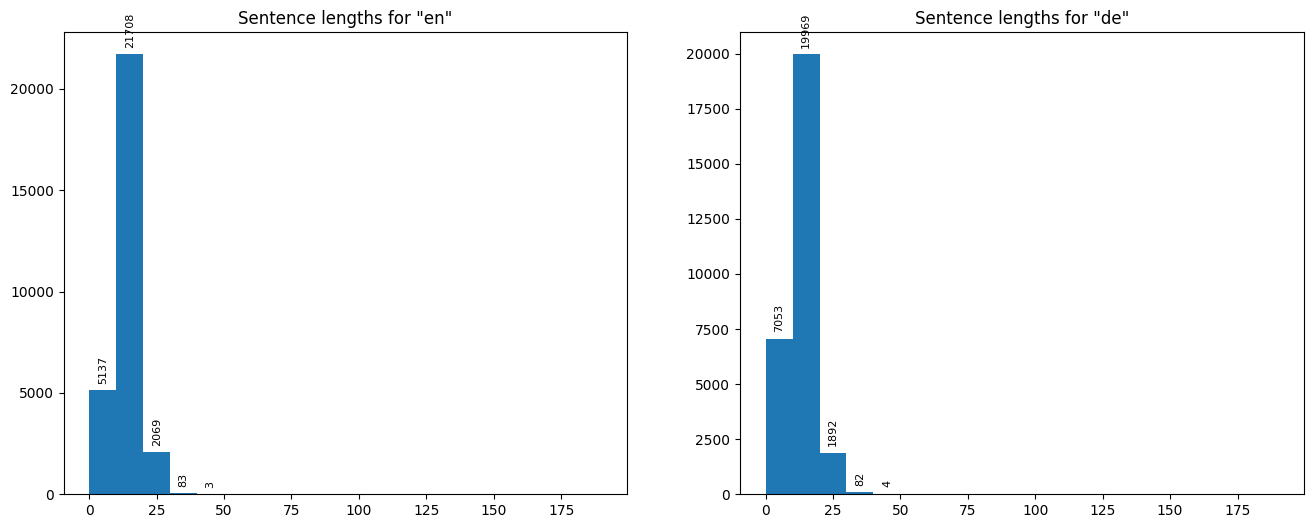

In [141]:
# Plot histograms for lengths
plt.figure(figsize=(16,6))
bins_list = range(0,200,10)
ax = plt.subplot(1, 2, 1)
n,bins,patches = plt.hist(src_lens, bins=bins_list);
for i in range(len(bins_list) - 1):
    if n[i] > 0: 
        ax.text(bins[i] + 5, n[i] + 400, str(int(n[i])), fontsize=8, ha='center', rotation=90)
plt.title(f'Sentence lengths for "{src_lang}"')
ax = plt.subplot(1, 2, 2)
n,bins,patches = plt.hist(tgt_lens, bins=bins_list);
for i in range(len(bins_list) - 1):
    if n[i] > 0: 
        ax.text(bins[i] + 5, n[i] + 400, str(int(n[i])), fontsize=8, ha='center', rotation=90)
plt.title(f'Sentence lengths for "{tgt_lang}"')
plt.show()

# Training

In [34]:
# Imports
import torch
import torch.nn
from tqdm import tqdm
from pathlib import Path
# from torch.utils.tensorboard import SummaryWriter
import warnings
import numpy as np
import pandas as pd

### Training Config

In [35]:
# Function to return config
def get_training_config():

    # Config
    batch_size = 256
    num_epochs = 30
    learning_rate = 1e-4
    seq_len = 50 # Selected based on histograms
    d_model = 512
    dropout = 0.1
    d_ff = 2048
    N = 6
    betas = (0.9, 0.999)
    lang_src = "en"
    lang_tgt = "de"
    model_dir = "weights"
    model_file = "tf_model_"
    preload = None
    tokenizer_file = "tokenizer_{0}.json"
    experiment_name = "runs/tf_model_"

    # Return config
    return {
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "seq_len": seq_len,
        "d_model": d_model,
        "d_ff": d_ff,
        "N": N,
        "lang_src": lang_src,
        "lang_tgt": lang_tgt,
        "model_dir": model_dir,
        "model_file": model_file,
        "preload": preload,
        "tokenizer_file": tokenizer_file,
        "experiment_name": experiment_name,
        "dropout": dropout,
        "betas": betas
    }

### Training Utils

In [36]:
# Validation function
def get_val_loss(model, val_ds, tokenizer_src, tokenizer_tgt, max_len, device, loss_fn):

    # Set model to eval mode
    model.eval()

    # Evaluate with no grad
    with torch.no_grad():

        # Maintain losses list
        losses = []
        
        # Loop  batches
        for batch in val_ds:

            # Get data for each batch
            encoder_input = batch['encoder_input'].to(device) # (batch_size, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (batch_size, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (batch_size, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (batch_size, 1, seq_len, seq_len)
            label = batch['label'].to(device) # (batch_size, seq_len)

            # Run the input through model
            encoder_output = model.encode(encoder_input, encoder_mask) # (batch_size, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (batch_size, seq_len, d_model)
            output = model.project(decoder_output) # (batch_size, seq_len, tgt_vocab_size)

            # Compare labels and calculate loss
            loss = loss_fn(output.view(-1,tokenizer_tgt.get_vocab_size()), label.view(-1))
            losses.append(loss.item())
            
        # Return mean loss
        return np.mean(losses)

In [37]:
# Run validation on few samples
def run_validation(model, val_ds, tokenizer_src, tokenizer_tgt, max_len, device, tqdm_print_fn, global_state, writer, num_examples=2, print_output=True):

    # Set model to eval mode
    model.eval()

    # Store results
    inputs = []
    labels = []
    preds = []

    # Evaluate with no grad
    with torch.no_grad():

        # Loop `num_examples` batches
        c = 0
        for batch in val_ds:
            c+=1
            if(num_examples>0 and c>num_examples): break

            # Generate model output
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            model_output = inference_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Get texts
            src_text = batch['src_text']
            tgt_text = batch['tgt_text']
            pred_text = tokenizer_tgt.decode(model_output.detach().cpu().numpy())

            # Add to results array
            inputs += src_text
            labels += tgt_text
            preds.append(pred_text)

            # Print to console
            if(print_output):
                tqdm_print_fn('-'*120)
                tqdm_print_fn(f'SOURCE: {src_text}')
                tqdm_print_fn(f'TARGET: {tgt_text}')
                tqdm_print_fn(f'PREDICTED: {pred_text}')

    # Return results
    return inputs, labels, preds

In [38]:
# Generate model and training loop
def train_model(config):

    # Init device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device {device}')

    # Create output dirs required
    Path(config['model_dir']).mkdir(parents=True, exist_ok=True)

    # Load dataset
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_dataset(dataset_name, config['lang_src'], config['lang_tgt'], config['tokenizer_file'], config['seq_len'], config['batch_size'])
    n_batches = len(train_dataloader)
    
    # Build model object
    model = build_transformer_model(tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size(), config['seq_len'], config['seq_len'], config['d_model'], dropout=config['dropout'], N=config['N'], d_ff=config['d_ff']).to(device)

    # Start tensorboard
    # writer = SummaryWriter(f"{config['experiment_name']}1")

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], betas=config['betas'], eps=1e-9)

    # Init list to store epoch loss data
    losses = []

    # Prepare to resume training if required
    initial_epoch = 0
    global_step = 0
    if(config['preload']):
        model_filename = f"{Path('.')}/{config['model_dir']}/{config['model_file']}{config['preload']}.pt"
        print(f'Loading model from {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
        losses = state['losses']

    # Setup loss function
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id(SPECIAL_TOKENS[PAD_IDX]), label_smoothing=0.1).to(device)

    # Training loop
    for epoch in range(initial_epoch, config['num_epochs']):

        # Store loss data for this epoch
        epoch_train_losses = []
        epoch_val_loss = None 

        # Create batch iterator from model iterator and loop batches
        batch_iterator = tqdm(train_dataloader, desc=f'Epoch {epoch+1:02d}')
        batch_counter = 0
        for batch in batch_iterator:
            batch_counter += 1

            # Set model to train mode
            model.train()

            # Get data for each batch
            encoder_input = batch['encoder_input'].to(device) # (batch_size, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (batch_size, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (batch_size, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (batch_size, 1, seq_len, seq_len)
            label = batch['label'].to(device) # (batch_size, seq_len)

            # Run the input through model
            encoder_output = model.encode(encoder_input, encoder_mask) # (batch_size, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (batch_size, seq_len, d_model)
            output = model.project(decoder_output) # (batch_size, seq_len, tgt_vocab_size)

            # Compare labels and calculate loss
            loss = loss_fn(output.view(-1,tokenizer_tgt.get_vocab_size()), label.view(-1))
            epoch_train_losses.append(loss.item())

            # Tensorboard
            # writer.add_scalar('train loss', loss.item(), global_step)

            # Backpropagate
            loss.backward()

            # Optimizer step
            optimizer.step()
            optimizer.zero_grad()

            # Increment global step
            global_step += 1

            # Calculate validation if last batch, doing in loop to update val loss in tqdm
            if(batch_counter == n_batches):
                val_loss = get_val_loss(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, loss_fn)
                batch_iterator.set_postfix({'train_loss':f'{np.mean(epoch_train_losses):6.3f}', 'val_loss':f'{val_loss.item():6.3f}'})
                epoch_val_loss = val_loss.item()
            else:
                batch_iterator.set_postfix({'loss':f'{loss.item():6.3f}'})

        # Run validation
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda message:batch_iterator.write(message), global_step, None)

        # Add loss data to list
        losses.append({
            'epoch': epoch,
            'train_loss': np.mean(epoch_train_losses),
            'val_loss': epoch_val_loss
        })

        # Save model at end of each epoch
        model_filename = f"{Path('.')}/{config['model_dir']}/{config['model_file']}{epoch+1:02d}.pt"
        torch.save({
            'epoch':epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step,
            'losses': losses
        }, model_filename)

In [42]:
torch.rand(32,100,1000).shape

torch.Size([32, 100, 1000])

In [43]:
torch.rand(32,100,1000).view(-1,1000).shape

torch.Size([3200, 1000])

In [44]:
torch.rand(32,100).view(-1).shape

torch.Size([3200])

### Training

In [45]:
# Filter warnings
warnings.filterwarnings('ignore')

**Model 1 (Default)**:\
d_model=512, d_ff=2048, N=6, dropout=0.1

In [66]:
# Train
config = get_training_config()
train_model(config)

Using device cuda
Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45


Epoch 01: 100%|██████████| 114/114 [01:13<00:00,  1.54it/s, train_loss=6.147, val_loss=5.108]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two dogs playing with a blue and green ball.']
TARGET: ['Zwei Hunde spielen mit einem blau-grünen Ball.']
PREDICTED: Ein Mann in einem auf einem . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy with glasses wearing a bright yellow shirt is standing in a parking lot.']
TARGET: ['Ein Junge mit Brille und einem leuchtend gelben T-Shirt steht auf einem Parkplatz.']
PREDICTED: Ein Mann in einem mit einem und . . .


Epoch 02: 100%|██████████| 114/114 [01:19<00:00,  1.44it/s, train_loss=4.855, val_loss=4.405]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man and a boy are sitting at an altar both are holding bells.']
TARGET: ['Ein Mann und ein Junge sitzen an einem Altar und halten beide eine Glocke.']
PREDICTED: Ein Mann und ein Mann in einem und ein Mann . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two girls are seated at a table and working on craft projects.']
TARGET: ['Zwei Mädchen sitzen an einem Tisch und arbeiten an kunsthandwerklichen Projekten.']
PREDICTED: Zwei Männer Mädchen auf einer und ein . . . . . . . . . . . . .


Epoch 03: 100%|██████████| 114/114 [01:16<00:00,  1.49it/s, train_loss=4.364, val_loss=4.049]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A black poodle plays with another dog in a dry field.']
TARGET: ['Ein schwarzer Pudel spielt mit einem anderen Hund auf einem ausgedörrten Feld.']
PREDICTED: Ein Hund Hund mit einem Hund mit einem Hund . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A white blond lady wearing a blue bag riding a scooter.']
TARGET: ['Eine weißblonde Dame mit einer blauen Tasche fährt auf einem Roller.']
PREDICTED: Eine Frau in einem weißen Hemd mit einer Frau . . . . . . . . . .


Epoch 04: 100%|██████████| 114/114 [01:20<00:00,  1.42it/s, train_loss=4.044, val_loss=3.752]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ["A bearded bald man in a tan striped shirt rests his head on another man's arm."]
TARGET: ['Ein glatzköpfiger Mann mit Bart in einem hellbraun gestreiften Hemd lehnt seinen Kopf an den Arm eines anderen Mannes.']
PREDICTED: Ein Mann in einem Mann mit einem Mann auf dem Mann auf dem Mann auf dem Fahrrad . . . . . . . . . . Mann .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Women in beach bikinis play volleyball in the sunny weather.']
TARGET: ['Frauen in Strandbikinis spielen Volleyball bei sonnigem Wetter.']
PREDICTED: Frauen Frauen in spielen im Strand . . . . .


Epoch 05: 100%|██████████| 114/114 [01:22<00:00,  1.39it/s, train_loss=3.770, val_loss=3.521]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in an apron standing in front of food beneath a menu.']
TARGET: ['Ein Mann mit einer Schürze steht vor Esswaren, die sich unter einer Speisekarte befinden.']
PREDICTED: Ein Mann in steht vor einer steht vor einem . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A toddler in a denim hats plays in a tire.']
TARGET: ['Ein kleines Kind mit Jeanshut spielt in einem Reifen.']
PREDICTED: Ein Kind mit spielt in einem . . . . . . . . . . . . . . .


Epoch 06: 100%|██████████| 114/114 [01:22<00:00,  1.38it/s, train_loss=3.545, val_loss=3.351]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A snowboarder is jumping in the air next to the ski lift.']
TARGET: ['Ein Snowboarder springt neben dem Skilift in die Luft.']
PREDICTED: Ein Snowboarder springt springt in die neben der . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Man on phone in business suit walking down a busy street.']
TARGET: ['Telefonierender Mann in einem Geschäftsanzug geht eine belebte Straße entlang.']
PREDICTED: Ein Mann auf Mann in einem Mann geht Straße entlang . entlang . . . . . . . . . . . . . .


Epoch 07: 100%|██████████| 114/114 [01:19<00:00,  1.43it/s, train_loss=3.355, val_loss=3.218]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['This is some sort of band or symphony practicing.']
TARGET: ['Das ist eine Art Band oder Orchester beim Üben.']
PREDICTED: Ein Mann . . . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Many of the chairs are empty with only a few people enjoying the sun.']
TARGET: ['Viele Stühle sind leer und nur einige wenige Menschen genießen die Sonne.']
PREDICTED: Viele Leute auf fahren mit mit einer Straße . . . . . . . . . . . . .


Epoch 08: 100%|██████████| 114/114 [01:20<00:00,  1.42it/s, train_loss=3.193, val_loss=3.102]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a domino mask and severe hair is at a party.']
TARGET: ['Eine Frau mit einer Domino-Maske und streng frisiertem Haar auf einer Party.']
PREDICTED: Eine Frau mit einer und . . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young dirty faced asian girl carrying a pillow.']
TARGET: ['Ein kleines asiatisches Mädchen mit schmutzigem Gesicht trägt ein Kissen.']
PREDICTED: Ein junger junger Mann , kleines Mädchen , das kleines Mädchen . . . . . . . . . . . .


Epoch 09: 100%|██████████| 114/114 [01:19<00:00,  1.44it/s, train_loss=3.049, val_loss=2.997]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A bicyclist is doing a trick in midair.']
TARGET: ['Ein Radfahrer vollführt ein Kunststück in der Luft.']
PREDICTED: Ein Radfahrer Radfahrer macht einen Trick in der Luft . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ["A man with a disability who doesn't have legs is walking with another man who is entered into a marathon."]
TARGET: ['Ein Mann mit einer Behinderung, der keine Beine hat, geht neben einem anderen Mann, der zu einem Marathon angemeldet ist.']
PREDICTED: Ein Mann mit einem , der anderen Mann , die andere Mann mit einem anderen Mann ist ein anderer Mann . . . . . . . . . . . . einen anderen Mann


Epoch 10: 100%|██████████| 114/114 [01:16<00:00,  1.49it/s, train_loss=2.922, val_loss=2.921]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men are observing another as he puts the finishing touches on wet cement.']
TARGET: ['Zwei Männer beobachten einen anderen, während dieser am nassen Zement letzte Hand anlegt.']
PREDICTED: Zwei Männer schauen zu , während ein anderer sieht zu . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A rickshaw operator waiting for his next costumer.']
TARGET: ['Ein Rikschabetreiber wartet auf seinen nächsten Kunden.']
PREDICTED: Eine wartet auf der . . . . . . . . . . . . . . . . .


Epoch 11: 100%|██████████| 114/114 [01:17<00:00,  1.47it/s, train_loss=2.807, val_loss=2.845]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Man with Mardi Gras Beads around his neck holding pole with banner']
TARGET: ['Mann mit Mardi-Gras-Perlen um den Hals trägt Stange mit Banner']
PREDICTED: Ein Mann mit um den Kopf - mit der Hand hält eine . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['4 people trying to fix a bike on a park']
TARGET: ['Vier Menschen versuchen in einem Park, ein Fahrrad zu reparieren']
PREDICTED: Vier Personen versuchen zu zu einem Fahrrad zu fahren . .


Epoch 12: 100%|██████████| 114/114 [01:17<00:00,  1.47it/s, train_loss=2.705, val_loss=2.786]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two construction workers assist in the loading of a dump truck at an urban construction site.']
TARGET: ['Zwei Bauarbeiter helfen beim Beladen eines Kippers auf einer innerstädtischen Baustelle.']
PREDICTED: Zwei Bauarbeiter bei der eines auf einer Baustelle . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Scene of a person shoveling snow citizens walking around in a cold winter environment']
TARGET: ['Szene eines Mannes beim Schneeschippen, Bürger, die in einer kalten, winterlichen Umgebung herumlaufen']
PREDICTED: Eine Person , die durch den Schnee geht in einer . . . . . . . . . . . .


Epoch 13: 100%|██████████| 114/114 [01:20<00:00,  1.42it/s, train_loss=2.612, val_loss=2.741]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group of young Asian men walking in a marathon.']
TARGET: ['Eine Gruppe junger asiatischer Männer läuft bei einem Marathon.']
PREDICTED: Eine Gruppe von junge asiatische Männer gehen an einem Marathon . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two people stand in front of a building.']
TARGET: ['Zwei Menschen stehen vor einem Gebäude.']
PREDICTED: Zwei Personen stehen vor einem Gebäude . . . . . . . . . .


Epoch 14: 100%|██████████| 114/114 [01:19<00:00,  1.43it/s, train_loss=2.530, val_loss=2.711]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two young Asian boys spar with each other.']
TARGET: ['Zwei kleine asiatische Jungen streiten miteinander.']
PREDICTED: Zwei kleine Jungen Jungen miteinander . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A balding man in red sunglasses wearing a green shirt standing in front of a building.']
TARGET: ['Ein Mann mit beginnender Glatze und roter Sonnenbrille in einem grünen Hemd steht vor einem Gebäude.']
PREDICTED: Ein Mann mit Mann mit Sonnenbrille und mit Sonnenbrille in einer grünen Hemd steht vor einem Gebäude . . . . . . . . . . . .


Epoch 15: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, train_loss=2.456, val_loss=2.671]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A mother in a blue beret and blue shoes with her two sons.']
TARGET: ['Eine Mutter mit einer blauen Baskenmütze und blauen Schuhen und ihren zwei Söhnen.']
PREDICTED: Eine Mutter mit blauem blauen und blauen Schuhen mit zwei Polizisten auf zwei Kinder . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A singer doing a stage dive into the crowd.']
TARGET: ['Ein Sänger beim Stagediving in der Menschenmenge.']
PREDICTED: Ein Sänger Sänger auf einer Bühne in die Band . . . . . . . . . . . . . . . .


Epoch 16: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, train_loss=2.389, val_loss=2.639]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People walk on a metropolitan sidewalk in front of a bar and grill.']
TARGET: ['Menschen gehen vor einer Imbissbar auf einem Gehweg in einer Großstadt.']
PREDICTED: Leute gehen durch eine Person durch vor einer Bar und einem Grill . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men sitting outside having a conversation by a Free Advice sign.']
TARGET: ['Zwei Männer sitzen im Freien und unterhalten sich neben einem Schild für kostenlose Beratung.']
PREDICTED: Zwei Männer sitzen draußen unterhalten sich neben einem Schild mit einem Schild mit . . . . . . . . . . . . . .


Epoch 17: 100%|██████████| 114/114 [01:16<00:00,  1.50it/s, train_loss=2.326, val_loss=2.640]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men in the military are playing baseball.']
TARGET: ['Zwei Männer beim Militär spielen Baseball.']
PREDICTED: Zwei Männer in der Soldaten spielen Baseball . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People are dancing and clapping there hands.']
TARGET: ['Menschen tanzen und klatschen in die Hände.']
PREDICTED: Leute tanzen und tanzen . . . . . . . . . . . . . . . . . .


Epoch 18: 100%|██████████| 114/114 [01:18<00:00,  1.45it/s, train_loss=2.267, val_loss=2.616]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two people stand in front of a building.']
TARGET: ['Zwei Menschen stehen vor einem Gebäude.']
PREDICTED: Zwei Personen stehen vor einem Gebäude . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A little girl stands in a puddle outside.']
TARGET: ['Ein kleines Mädchen steht draußen in einer Pfütze.']
PREDICTED: Ein kleines Mädchen steht in einer Pfütze im Freien . . . . . . . . .


Epoch 19: 100%|██████████| 114/114 [01:16<00:00,  1.49it/s, train_loss=2.215, val_loss=2.604]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A chef working in a kitchen using a knife.']
TARGET: ['Ein Koch arbeitet in einer Küche mit einem Messer.']
PREDICTED: Ein Koch arbeitet in einer Küche benutzt ein Messer . . . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ["A man in a sleek white shirt gazes into the woman's eyes while holding on to the back of her black and pink dress."]
TARGET: ['Ein Mann in einem schnittigen weißen Hemd blickt der Frau in die Augen, während er sie am Rücken ihres schwarz-pinken Kleides hält.']
PREDICTED: Ein Mann in einem weißen Hemd blickt in die Frau blickt auf den Arm und mit einem rosa und schwarzen Kleid an . . . . . . . . . . . sich in einem rosa


Epoch 20: 100%|██████████| 114/114 [01:15<00:00,  1.51it/s, train_loss=2.166, val_loss=2.587]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A girl leads her dog over a hurdle.']
TARGET: ['Ein Mädchen führt seinen Hund über eine Hürde.']
PREDICTED: Ein Mädchen führt vor ihrem Hund über eine Hürde . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three young children stand around a blue and white barrel.']
TARGET: ['Drei kleine Kinder stehen um ein blau-weißes Fass herum.']
PREDICTED: Drei Kinder Kinder stehen um einen blau - weiße herum . . . . . . . . . . .


In [44]:
# Train 10 more epochs
config = get_training_config()
config['num_epochs'] = 30
config['preload'] = 20
train_model(config)

Using device cuda
Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45
Loading model from ./weights/tf_model_20.pt


Epoch 21: 100%|██████████| 121/121 [01:18<00:00,  1.55it/s, train_loss=2.123, val_loss=2.588]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a gray hat and tank top with black shorts doing a handstand.']
TARGET: ['Ein Mann mit einer grauen Mütze, Trägershirt und schwarzen Shorts macht einen Handstand.']
PREDICTED: Ein Mann mit grauem Hut und Trägerhemd und schwarzen Shorts macht einen Handstand macht Handstand . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A black dog swimming in the water with a tennis ball in his mouth']
TARGET: ['Ein schwarzer Hund schwimmt mit einem Tennisball im Maul im Wasser']
PREDICTED: Ein schwarzer Hund schwimmt im Wasser mit einem Tennisball im Maul . . . . . . . . . . . . . . .


Epoch 22: 100%|██████████| 121/121 [01:18<00:00,  1.54it/s, train_loss=2.079, val_loss=2.577]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a blue shirt blowing a trumpet.']
TARGET: ['Ein Mann in einem blauen Hemd bläst auf einer Trompete.']
PREDICTED: Ein Mann in blauem Hemd bläst Trompete Trompete . . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['An ATV attempts to get out of a ditch.']
TARGET: ['Ein Geländewagen versucht, aus einem Graben herauszukommen.']
PREDICTED: Ein Läufer versucht zu . . . . . . . . . . .


Epoch 23: 100%|██████████| 121/121 [01:18<00:00,  1.55it/s, train_loss=2.037, val_loss=2.579]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People play in a fountain at twilight.']
TARGET: ['Menschen spielen in der Dämmerung in einem Springbrunnen.']
PREDICTED: Menschen spielen in einem Brunnen in der Nacht . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A white dog with brown marks jumps from the bank into the water.']
TARGET: ['Ein weißer Hund mit braunen Flecken springt vom Ufer aus in das Wasser.']
PREDICTED: Ein weißer Hund mit braunen springt ins Wasser . . . . . . . . . . . . .


Epoch 24: 100%|██████████| 121/121 [01:15<00:00,  1.60it/s, train_loss=1.997, val_loss=2.577]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy prepares to kick a goal shot']
TARGET: ['Ein Junge setzt zu einem Torschuss an']
PREDICTED: Ein Junge bereitet darauf vor . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A foreign woman is sitting with a lot of colorful fabric.']
TARGET: ['Da sitzt eine ausländische Frau mit sehr viel buntem Stoff.']
PREDICTED: Eine Frau , die Frau sitzt mit vielen bunten Stoff . . . . . . . . . . . . . . . . . . .


Epoch 25: 100%|██████████| 121/121 [01:13<00:00,  1.65it/s, train_loss=1.959, val_loss=2.577]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men talk to each other behind an organ while a lone woman stands to their right.']
TARGET: ['Zwei Männer unterhalten sich hinter einer Orgel, während rechts eine einzelne Frau steht.']
PREDICTED: Zwei Männer unterhalten sich hinter einer , während eine Frau steht hinter ihr nach rechts . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A large group of people watching a performer on a stage.']
TARGET: ['Eine große Gruppe von Menschen sieht einem Künstler auf einer Bühne zu.']
PREDICTED: Eine große Gruppe Leute zu sehen zu einem Straßenkünstler zu . . . . . . . . . . . . . . . . . . .


Epoch 26: 100%|██████████| 121/121 [01:19<00:00,  1.53it/s, train_loss=1.925, val_loss=2.590]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Photographers at a site making a documentary.']
TARGET: ['Fotografen machen eine Dokumentation an einem Veranstaltungsort.']
PREDICTED: Fotografen auf einer Baustelle . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A brunet male in a brown blazer talking to an audience at a comedian show.']
TARGET: ['Ein braunhaariger Mann in einem braunen Blazer spricht vor Publikum bei einer Comedy-Show.']
PREDICTED: Ein Mann in brauner spricht vor einer . . . . . . . . . . . . . . . .


Epoch 27: 100%|██████████| 121/121 [01:18<00:00,  1.54it/s, train_loss=1.892, val_loss=2.581]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a white shirt and black pants hula hoops as a large group of people look on.']
TARGET: ['Eine Frau in einem weißen T-Shirt und schwarzen Hosen tanzt Hula-Hoop, während ihr eine große Gruppe von Menschen zusieht.']
PREDICTED: Eine Frau in einer weißen Hemd und schwarzen Hosen Hula - Hosen mit Personen schaut zu . Personen . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in blue and red face paint poses for a picture with a woman.']
TARGET: ['Ein Mann mit blau-rot geschminktem Gesicht posiert mit einer Frau für ein Foto.']
PREDICTED: Ein Mann in blau und roter Gesichtsbemalung für ein Foto mit einer Frau posiert für eine Frau . . . . . . . . . . . . . . . .


Epoch 28: 100%|██████████| 121/121 [01:19<00:00,  1.52it/s, train_loss=1.862, val_loss=2.603]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man with sunglasses is helping a child with sunglasses slide down a slide.']
TARGET: ['Ein Mann mit Sonnenbrille hilft einem Kind mit Sonnenbrille eine Rutsche herunterzurutschen.']
PREDICTED: Ein Mann mit Sonnenbrille hilft einem Kind zu Kind mit einer Rutsche herunter . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man wearing a black t-shirt is playing seven string bass a stage.']
TARGET: ['Ein Mann in einem schwarzen T-Shirt spielt einen siebensaitigen Bass auf einer Bühne.']
PREDICTED: Ein Mann in schwarzem T - T - Shirt spielt an der Bühne mit . . . . . . . . . . . . . .


Epoch 29: 100%|██████████| 121/121 [01:18<00:00,  1.55it/s, train_loss=1.831, val_loss=2.604]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A dog treads through a shallow area of water located on a rocky mountainside.']
TARGET: ['Ein Hund geht durch eine seichte Wasseransammlung, die sich an einem felsigen Berghang befindet.']
PREDICTED: Ein Hund durch eine Wasser an einem felsigen Gegend . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Woman with a white shirt and banks lounging on a couch inside of a house.']
TARGET: ['Frau in einem weißen T-Shirt und Hosen entspannt sich auf einem Sofa in einem Haus.']
PREDICTED: Eine Frau in weißem Hemd und auf einer Couch sitzt auf einem Haus . . . . . . . . . . .


Epoch 30: 100%|██████████| 121/121 [01:19<00:00,  1.52it/s, train_loss=1.806, val_loss=2.602]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ["Two men wearing sombrero's in New York City."]
TARGET: ['Zwei Männer tragen Sombreros in New York City.']
PREDICTED: Zwei Männer mit Sombrero in New New York City . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two man are paddling a kayak along a river with green trees on either side.']
TARGET: ['Zwei Männer paddeln in einem Kajak einen Fluss mit grünen Bäumen auf beiden Seiten entlang.']
PREDICTED: Zwei Mann paddelt Kajak paddeln an einem Kajak entlang , auf grünen Bäumen . . . . . . . . .


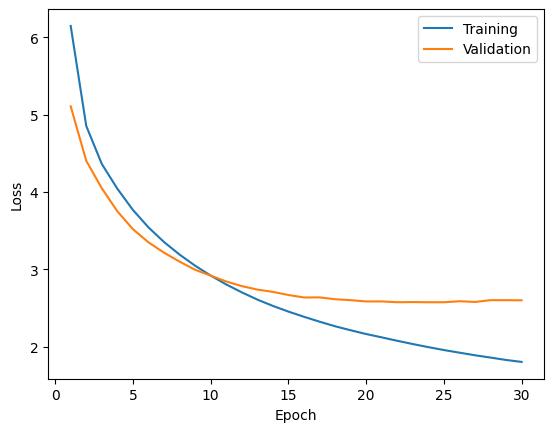

In [9]:
# Plot loss curves
model_state = torch.load('./weights/tf_model_30.pt')
loss_df = pd.DataFrame(model_state['losses'])
plt.plot(loss_df['epoch']+1, loss_df['train_loss'])
plt.plot(loss_df['epoch']+1, loss_df['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training", "Validation"], loc="upper right")

**Model 2**:\
d_model=512, d_ff=2048, N=3, dropout=0.1

In [51]:
# Train
config = get_training_config()
config['batch_size']=384
config['N']=3
config['model_dir']="weights_model_2"
train_model(config)

Using device cuda


Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/29000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1014 [00:00<?, ? examples/s]

Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45


Epoch 01: 100%|██████████| 76/76 [00:38<00:00,  1.97it/s, train_loss=6.550, val_loss=5.375]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Children are staring out the window of a blue building with red shutters.']
TARGET: ['Kinder starren aus dem Fenster eines blauen Gebäudes mit roten Fensterläden.']
PREDICTED: Ein Mann in einem .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A little girl peering over a blue wall.']
TARGET: ['Ein kleines Mädchen späht über eine blaue Mauer.']
PREDICTED: Ein Mann in einem . .


Epoch 02: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=5.151, val_loss=4.694]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A girl with face paint and an orange sweater stands with her party.']
TARGET: ['Ein Mädchen mit geschminktem Gesicht und einem orangen Pullover steht bei ihrer Truppe.']
PREDICTED: Ein Mädchen mit einem und mit einem . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Pottery and cars are shown in a parking lot with a man in a blue outfit is leaning against the front of his car.']
TARGET: ['Das Bild zeigt Tonwaren und Autos auf einem Parkplatz und einen blau gekleideten Mann, der an der Vorderseite seines Autos lehnt.']
PREDICTED: Ein Mann mit einem mit einem . . . . . .


Epoch 03: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=4.628, val_loss=4.285]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man jumps rope while a crowd of people watch him.']
TARGET: ['Ein Mann übt Seilspringen, während ihm eine Menschenmenge dabei zusieht.']
PREDICTED: Ein Mann Ein Mann , während ein Mann , während ein Mann . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy in a red shirt trying to play a guitar.']
TARGET: ['Ein Junge in einem roten T-Shirt versucht, Gitarre zu spielen.']
PREDICTED: Ein Junge in einem blauen Hemd und ein Junge in einem . . . . . . . . . . .


Epoch 04: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=4.273, val_loss=3.959]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman applies face paint while a boy with a Mohawk holds a mirror.']
TARGET: ['Eine Frau trägt Gesichtsschminke auf, während ein Junge mit Irokesenschnitt einen Spiegel hält.']
PREDICTED: Eine Frau Frau mit einem und hält ein mit einem . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men, one man selling fruit the other inspecting the fruit and conversing with the seller.']
TARGET: ['Zwei Männer, von denen der eine Obst verkauft und der andere das Obst prüft und sich mit dem Verkäufer unterhält.']
PREDICTED: Zwei Männer , die , während ein Mann , während ein Mann , während ein . . . . . . . . . . .


Epoch 05: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=3.983, val_loss=3.704]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two girls playing on a tree with their dog.']
TARGET: ['Zwei Mädchen spielen mit ihrem Hund auf einem Baum.']
PREDICTED: Zwei Mädchen spielen auf einem Hund mit einem Hund . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young girl is swimming in a pool.']
TARGET: ['Ein kleines Mädchen schwimmt in einem Pool.']
PREDICTED: Ein Mädchen Mädchen in einem . . . . . . . . . . . . . . . . . . . . . .


Epoch 06: 100%|██████████| 76/76 [00:38<00:00,  1.97it/s, train_loss=3.748, val_loss=3.516]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a harness climbing a rock wall']
TARGET: ['Ein Mann in einem Klettergurt klettert an einer Felswand']
PREDICTED: Ein Mann in einem mit einer Wand . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A policeman stopping a vehicle on the side of the road.']
TARGET: ['Ein Polizist hält ein Fahrzeug am Straßenrand an.']
PREDICTED: Ein älterer Mann , der Nähe eines Straße . . . . . . . . . . . . . . . . . .


Epoch 07: 100%|██████████| 76/76 [00:38<00:00,  1.99it/s, train_loss=3.553, val_loss=3.358]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a wheelchair and wearing a red jogging suit is carrying a torch.']
TARGET: ['Ein Mann in einem Rollstuhl und einem roten Jogginganzug trägt eine Fackel.']
PREDICTED: Ein Mann in einem und mit einem roten Hemd trägt eine . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Man in a suit smoking a cigar and reading a paper walking on the street.']
TARGET: ['Mann in einem Anzug, der eine Zigarre raucht und eine Zeitung liest, geht auf der Straße.']
PREDICTED: Ein Mann im Anzug und eine Frau und eine Straße entlang und eine Straße entlang . Straße entlang . . . . . . . . . Straße entlang . . geht


Epoch 08: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=3.384, val_loss=3.229]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A black dog standing in some grass holding a white plastic item in its mouth.']
TARGET: ['Ein schwarzer Hund steht im Gras und hält einen weißen Plastikgegenstand in seinem Maul.']
PREDICTED: Ein schwarzer Hund steht im Gras und mit einem weißen Maul Maul . Maul . Maul . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man sitting in clear shallow water beside a large rock face.']
TARGET: ['Ein Mann sitzt im klaren, seichten Wasser an einer großen Felswand.']
PREDICTED: Ein Mann sitzt in Wasser neben einem großen Wasser . Wasser . . . . . .


Epoch 09: 100%|██████████| 76/76 [00:38<00:00,  1.99it/s, train_loss=3.236, val_loss=3.123]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The man in the blue shirt is walking with the man in red.']
TARGET: ['Der Mann im blauen Shirt ist mit dem Mann in Rot unterwegs.']
PREDICTED: Der Mann im blauen Hemd geht mit einem Mann mit roten Mann . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The young girl is given rabbit ears by the young boy behind her.']
TARGET: ['Dem jungen Mädchen werden von dem kleinen Jungen hinter ihr Hasenohren gemacht.']
PREDICTED: Das Mädchen macht ein . hinter ihm hinter ihm . . . . . . . . . .


Epoch 10: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=3.108, val_loss=3.039]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Sailors stand at the top of a gangplank to a large boat.']
TARGET: ['Seeleute stehen oben an einer Laufplanke, die auf ein großes Schiff führt.']
PREDICTED: stehen am eines . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man is shaving while sitting on the beach in front of the ocean.']
TARGET: ['Ein Mann rasiert sich, während er am Strand vor dem Meer sitzt.']
PREDICTED: Ein Mann sitzt und im am Strand am Strand . Meer . . . . . . . . .


Epoch 11: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.993, val_loss=2.965]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The women is holding the boy while looking across the street.']
TARGET: ['Die Frau hält den Jungen fest, während sie über die Straße blickt.']
PREDICTED: Die Frau hält die Straße und schauen sich über die Straße . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A large group of people watching a performer on a stage.']
TARGET: ['Eine große Gruppe von Menschen sieht einem Künstler auf einer Bühne zu.']
PREDICTED: Eine große Gruppe Leute sieht zu zu . . . . . . . . . . . .


Epoch 12: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.891, val_loss=2.899]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Four men standing near a yellow car.']
TARGET: ['Vier Männer stehen bei einem gelben Auto.']
PREDICTED: Vier Männer stehen in der Nähe eines gelben Auto . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three people are running a race around a red track.']
TARGET: ['Drei Menschen laufen auf einer roten Bahn um die Wette.']
PREDICTED: Drei Personen laufen um einen Rennen um eine roten Weg . . . . . . .


Epoch 13: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.800, val_loss=2.858]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A little baby in a pink hat lying naked and sleeping.']
TARGET: ['Ein kleines Baby mit einer rosafarbenen Mütze liegt nackt da und schläft.']
PREDICTED: Ein kleines Baby mit einem rosafarbenen Hut mit Hut liegt und schläft . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A lady in a bright pink shirt is pulling a hot food cart.']
TARGET: ['Eine Dame in einer leuchtend pinkfarbenen Bluse zieht einen Wagen mit warmem Essen.']
PREDICTED: Eine Dame in einem rosafarbenen Oberteil zieht an einem Wagen mit Essen . . . . . . . . . . . .


Epoch 14: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.718, val_loss=2.803]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young boy in green practices juggling in a parking lot.']
TARGET: ['Ein kleiner Junge in Grün übt das Jonglieren auf einem Parkplatz.']
PREDICTED: Ein Junge in grünen grünen verkauft . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People are crossing a tree lined street in front of a building.']
TARGET: ['Menschen überqueren eine baumgesäumte Straße vor einem Gebäude.']
PREDICTED: Leute überqueren eine Straße vor einem Baum vor einem Gebäude . Gebäude . . . . . .


Epoch 15: 100%|██████████| 76/76 [00:38<00:00,  1.99it/s, train_loss=2.643, val_loss=2.767]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['With a tub resting on its outer roof, flags attached, the car is ready to take off for the rally.']
TARGET: ['Mit einer Badewanne auf dem Dach und befestigten Fahnen ist das Auto bereit für den Start der Rallye.']
PREDICTED: Ein Mann mit auf dem Dach - , steht , um für die für die Luft für die Luft . . . . . für die . . , um
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['2 females, 1 from germany and 1 from China, compete in a wrestling match on a mat.']
TARGET: ['Zwei Frauen, eine aus Deutschland und eine aus China, treten bei einem Ringkampf auf einer Matte gegeneinander an.']
PREDICTED: Zwei Frauen , ein Mann , von einem , machen in einem sich bei einem Volleyball auf einer Matte . . . . . . . .


Epoch 16: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.576, val_loss=2.743]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Kids conversing and learning in class.']
TARGET: ['Kinder einer Schulklasse sprechen miteinander und lernen.']
PREDICTED: Kinder unterhalten sich und essen im Freien . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A motocross rider is slightly airborne on a competition circuit jump.']
TARGET: ['Ein Motocrossfahrer wird bei einem Sprung auf einer Rennstrecke leicht durch die Luft getragen.']
PREDICTED: Ein Fahrer Fahrer Fahrer ist mitten in der Luft auf einem . . . . . . . . . . . . .


Epoch 17: 100%|██████████| 76/76 [00:38<00:00,  1.97it/s, train_loss=2.514, val_loss=2.727]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man and woman walk across an empty street.']
TARGET: ['Ein Mann und eine Frau überqueren eine leere Straße.']
PREDICTED: Ein Mann und eine Frau gehen über eine Straße . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group of people running a charity marathon.']
TARGET: ['Eine Gruppe von Menschen läuft bei einem Wohltätigkeitsmarathon.']
PREDICTED: Eine Gruppe Leute läuft bei einem Marathon . . . . . . . . .


Epoch 18: 100%|██████████| 76/76 [00:38<00:00,  1.99it/s, train_loss=2.456, val_loss=2.702]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A tattooed man wearing overalls on a stage holding a microphone.']
TARGET: ['Ein tätowierter Mann in einer Latzhose hält ein Mikrofon auf einer Bühne.']
PREDICTED: Ein Mann mit in einem Overall auf einer Bühne hält ein Mikrofon . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two women with their baby strollers walking along a leaves covered street.']
TARGET: ['Zwei Frauen gehen mit ihren Kinderwagen eine mit Blättern bedeckte Straße entlang.']
PREDICTED: Zwei Frauen mit ihren Baby Baby , die Straße entlang , gehen eine Treppe entlang . entlang . . . . .


Epoch 19: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.403, val_loss=2.676]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A trio of people are hiking throughout a heavily snowed path.']
TARGET: ['Drei Menschen wandern auf einem stark verschneiten Weg.']
PREDICTED: Ein von Menschen bei auf einem . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A bride and groom are taking pictures while two men stand nearby.']
TARGET: ['Eine Braut und ein Bräutigam machen Fotos, während in der Nähe zwei Männer stehen.']
PREDICTED: Eine Braut und Bräutigam und ein Bräutigam machen Fotos stehen . stehen . . . . . . . .


Epoch 20: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.354, val_loss=2.660]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Sitting casually in a public place, a girl reads holding the book open with her hand on which is a butterfly ring.']
TARGET: ['Ein Mädchen sitzt in bequemer Haltung an einem öffentlichen Ort und liest ein Buch, das sie mit ihrer Hand geöffnet hält, an der sich ein Ring mit einem Schmetterling befindet.']
PREDICTED: Ein in auf einem öffentlichen Ort und liest ein Buch mit . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young girl standing in a grassy field.']
TARGET: ['Ein junges Mädchen steht auf einem grasbewachsenen Feld.']
PREDICTED: Ein Mädchen , das Mädchen steht auf einer Wiese . . . . . . . . .


Epoch 21: 100%|██████████| 76/76 [00:38<00:00,  1.97it/s, train_loss=2.305, val_loss=2.650]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A guy is running away from a black bull.']
TARGET: ['Ein Typ rennt vor einem schwarzen Bullen davon.']
PREDICTED: Ein Mann rennt von einem schwarzen Bullen . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The lady wearing a black hat is taking a picture while the snowfalls.']
TARGET: ['Die Frau mit einem schwarzen Hut macht ein Foto bei Schneefall.']
PREDICTED: Die Dame mit schwarzem Hut trägt ein Foto macht ein Foto . . . . . . . . . .


Epoch 22: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.263, val_loss=2.647]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A smiling young man walking on next to the beach wearing a baseball cap, blue t-shirt and jeans.']
TARGET: ['Ein lächelnder junger Mann geht in der Nähe des Strandes vorbei und trägt dabei eine Baseballkappe, ein blaues T-Shirt und Jeans.']
PREDICTED: Ein lächelnder junger Mann mit Baseballkappe am Strand entlang und blauen T - Shirt und blauen T - Shirt und Jeans . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A racing catamaran is lifted onto one hull in the water.']
TARGET: ['Ein Rennkatamaran wird im Wasser auf einen Rumpf gehoben.']
PREDICTED: Ein zu . . . . . . . . . .


Epoch 23: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.221, val_loss=2.629]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two people with white shirts walking up the sidewalk talking on their phones.']
TARGET: ['Zwei Menschen mit weißen Oberteilen gehen den Gehweg entlang und telefonieren dabei.']
PREDICTED: Zwei Personen mit weißen Hemden gehen auf dem Bürgersteig entlang und unterhalten sich . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Several girls are playing with flour.']
TARGET: ['Mehrere Mädchen spielen mit Mehl.']
PREDICTED: Mehrere Mädchen spielen mit . . . . . . . . .


Epoch 24: 100%|██████████| 76/76 [00:38<00:00,  1.97it/s, train_loss=2.185, val_loss=2.629]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Toddler in a green shirt is brushing his teeth with a yellow toothbrush, while being supervised by mom.']
TARGET: ['Kleines Kind in einem grünem Shirt putzt sich unter Mamas Aufsicht mit einer gelben Zahnbürste die Zähne.']
PREDICTED: Ein Kleinkind in grünem Hemd putzt sich die Zähne mit einer gelben Zähne und wird von einer Mutter geworfen . . . . . . . . . . wird von einer Mutter . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young woman practices a string instrument indoors.']
TARGET: ['Eine junge Frau spielt ein Saiteninstrument im Haus.']
PREDICTED: Eine junge Frau übt an einem ein . . . . . . . . . . . . . . .


Epoch 25: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.147, val_loss=2.618]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Several girls are playing with flour.']
TARGET: ['Mehrere Mädchen spielen mit Mehl.']
PREDICTED: Mehrere Mädchen spielen mit Getränken . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man and woman pose together on a cobblestone street.']
TARGET: ['Ein Mann und eine Frau posieren zusammen auf einer kopfsteingepflasterten Straße.']
PREDICTED: Ein Mann und eine Frau posieren zusammen auf einer gepflasterten Straße . . . . . . . . . . .


Epoch 26: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.113, val_loss=2.617]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young adult wearing jeans and a camouflage t-shirt playing a black electric guitar.']
TARGET: ['Ein junger Erwachsener mit Jeans und Tarn-T-Shirt spielt auf einer schwarzen E-Gitarre.']
PREDICTED: Ein junger Erwachsener in Jeans und ein T - T - Shirt spielt E - Gitarre . Gitarre . . . . . . . . . . . . . Gitarre . Gitarre
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A uniformed man in the Army is training a German Shepherd using an arm guard.']
TARGET: ['Ein uniformierter Mann von der Armee trainiert einen Deutschen Schäferhund mit einem Armschutz.']
PREDICTED: Ein Mann in Uniform . mit einem Schäferhund . . . . . . . . . . . . . . . . . .


Epoch 27: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.083, val_loss=2.618]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two people are talking near a red phone booth while construction workers rest nearby.']
TARGET: ['Zwei Menschen unterhalten sich bei einer roten Telefonzelle, während in der Nähe Bauarbeiter eine Pause machen.']
PREDICTED: Zwei Personen unterhalten sich in der Nähe an einem roten Telefon , während in der Nähe . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young woman practices a string instrument indoors.']
TARGET: ['Eine junge Frau spielt ein Saiteninstrument im Haus.']
PREDICTED: Eine junge Frau übt an einem ein . . . . . . . . . . . . . . . . . .


Epoch 28: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.049, val_loss=2.611]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a black dress is pushing a cart with thermos down a paved walkway.']
TARGET: ['Eine Frau in einem schwarzen Kleid schiebt einen Wagen mit Thermoskannen einen gepflasterten Fußgängerweg entlang.']
PREDICTED: Eine Frau in einem schwarzen Kleid schiebt einen Wagen mit einem Wagen mit gepflasterten Weg entlang . entlang . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Baby looking at the leaves on a branch of a tree.']
TARGET: ['Baby sieht sich die Blätter am Zweig eines Baumes an.']
PREDICTED: Ein Baby , das auf dem Laub auf einem Ast . . . . . . . . .


Epoch 29: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s, train_loss=2.021, val_loss=2.631]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two women dressed in all white and wearing high heels are walking on the street.']
TARGET: ['Zwei ganz in Weiß gekleidete Frauen mit hohen Absätzen gehen auf der Straße.']
PREDICTED: Zwei Frauen in weiß gekleidete Frauen mit hochhackigen Schuhen gehen die Straße entlang . gehen . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man on the coaching staff for OU has sunglasses on his head during a football game.']
TARGET: ['Ein Mann, der zum Trainerstab von OU gehört, trägt während eines Footballspiels eine Sonnenbrille auf dem Kopf.']
PREDICTED: Ein Mann auf den mit hat den Kopf auf dem Kopf hat bei einem Football . . . . . . . . . .


Epoch 30: 100%|██████████| 76/76 [00:38<00:00,  1.97it/s, train_loss=1.994, val_loss=2.626]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two women in spotted dresses walking down a sidewalk.']
TARGET: ['Zwei Frauen in gepunkteten Kleidern gehen einen Gehweg entlang.']
PREDICTED: Zwei Frauen in Kleidern gehen einen Bürgersteig entlang . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy in a red shirt trying to play a guitar.']
TARGET: ['Ein Junge in einem roten T-Shirt versucht, Gitarre zu spielen.']
PREDICTED: Ein Junge in rotem Hemd versucht , versucht zu spielen Gitarre . . . . . . . . . .


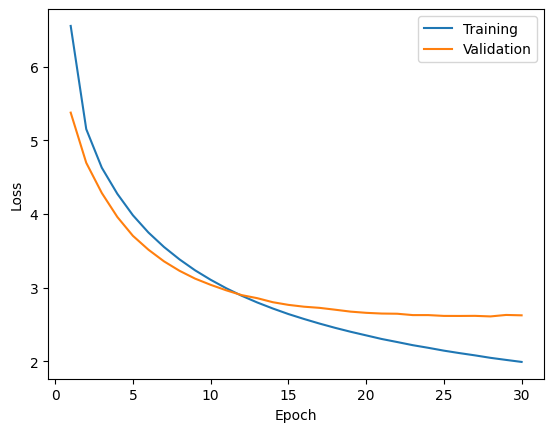

In [47]:
# Plot loss curves
model_state = torch.load('./weights_model_2/tf_model_30.pt')
loss_df = pd.DataFrame(model_state['losses'])
plt.plot(loss_df['epoch']+1, loss_df['train_loss'])
plt.plot(loss_df['epoch']+1, loss_df['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training", "Validation"], loc="upper right")

**Model 3**:\
d_model=512, d_ff=512, N=3, dropout=0.1

In [45]:
# Train
config = get_training_config()
config['batch_size']=512
config['N']=3
config['d_ff']=512
config['model_dir']="weights_model_3"
train_model(config)

Using device cuda


Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/29000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1014 [00:00<?, ? examples/s]

Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45


Epoch 01: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=6.978, val_loss=5.702]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A smiling woman in a peach tank top stands holding a mountain bike']
TARGET: ['Eine lächelnde Frau mit einem pfirsichfarbenen Trägershirt hält ein Mountainbike']
PREDICTED: Ein Mann in einem . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two young girls playing basketball, one in white attempting a layup while the other in red defends.']
TARGET: ['Zwei junge Mädchen spielen Basketball, wobei die eine in Weiß einen Korbleger versucht und die andere in Rot verteidigt.']
PREDICTED: Ein Mann in einem einem . . . . . . .


Epoch 02: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=5.479, val_loss=5.054]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A motocross rider is slightly airborne on a competition circuit jump.']
TARGET: ['Ein Motocrossfahrer wird bei einem Sprung auf einer Rennstrecke leicht durch die Luft getragen.']
PREDICTED: Ein Mann mit einem . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['An elderly man, wearing navy blue, is sitting on a bench along the street.']
TARGET: ['Ein älterer Mann in marineblauer Kleidung sitzt auf einer Bank an der Straße.']
PREDICTED: Ein Mann Mann in einem . . . . . . . .


Epoch 03: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=4.963, val_loss=4.596]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young blond-haired man speaks into a microphone.']
TARGET: ['Ein junger Mann mit blondem Haar spricht in ein Mikrofon.']
PREDICTED: Ein Mann in einem Mann in einem . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man stands in a mobile food stand, looking out the half-door.']
TARGET: ['Ein Mann steht in einem mobilen Essensstand und blickt über die halbhohe Tür.']
PREDICTED: Ein Mann in einem . . . . . . . . . . . . .


Epoch 04: 100%|██████████| 57/57 [00:35<00:00,  1.62it/s, train_loss=4.583, val_loss=4.264]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['There are many people in a building with some people cooking food.']
TARGET: ['Da sind viele Menschen in einem Gebäude und ein paar Menschen kochen etwas zu essen.']
PREDICTED: Eine Menschen Menschen in einer . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two women with their baby strollers walking along a leaves covered street.']
TARGET: ['Zwei Frauen gehen mit ihren Kinderwagen eine mit Blättern bedeckte Straße entlang.']
PREDICTED: Zwei Frauen Frauen mit auf einer Straße . . . . . . . .


Epoch 05: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=4.302, val_loss=4.009]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man crouches in front of a yellow wall.']
TARGET: ['Ein Mann kauert vor einer gelben Mauer.']
PREDICTED: Ein Mann Mann mit vor einer . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['One man and two women wearing shorts, walk down the street.']
TARGET: ['Ein Mann und zwei Frauen in Shorts gehen die Straße entlang.']
PREDICTED: Ein Mann und Frauen und eine Frau in die Straße entlang . Straße . . . . . . . . . . .


Epoch 06: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=4.069, val_loss=3.804]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a white shirt is sitting on a crate.']
TARGET: ['Ein Mann in einem weißen T-Shirt sitzt auf einer Kiste.']
PREDICTED: Ein Mann in einem Hemd sitzt auf einer . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A large dog is jumping in a fountain while a man in a black T-shirt and vest stands nearby.']
TARGET: ['Ein großer Hund springt in einem Springbrunnen herum, während ein Mann mit einem schwarzen T-Shirt und einer Weste danebensteht.']
PREDICTED: Ein Hund Hund springt in in einem Mann in einem Mann in einem weißen Hemd und in einem Mann in einem Mann in einer in der Hand . . . in einem . in einem Mann in einem weißen Hemd und in einem


Epoch 07: 100%|██████████| 57/57 [00:35<00:00,  1.62it/s, train_loss=3.870, val_loss=3.634]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young girl wearing a dress and sandals runs in the grass.']
TARGET: ['Ein kleines Mädchen in einem Kleid und Sandalen rennt durch das Gras.']
PREDICTED: Ein Mädchen Mädchen in einem Kleid und im Gras . Gras . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A vendor sits in the middle of a display of glasses at a street market in an Asian country.']
TARGET: ['Ein Verkäufer sitzt inmitten seines Brillensortiments auf einem Straßenmarkt in einem asiatischen Land.']
PREDICTED: Ein sitzt sitzt auf einer in einer . auf einer Straße . . . . . . . . . . . .


Epoch 08: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=3.698, val_loss=3.493]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men in red robes performing martial arts.']
TARGET: ['Zwei Männer in roten Gewändern führen eine Kampfsportübung durch.']
PREDICTED: Zwei Männer in roten in roten . . . . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman with blond-hair is drinking out of a glass.']
TARGET: ['Eine Frau mit blondem Haar trinkt aus einem Glas.']
PREDICTED: Eine Frau mit Haaren Haaren spielt . . . . . . . . . . . . . . . . . . . . . .


Epoch 09: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=3.549, val_loss=3.373]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group of black people performing in orange shirts in front of a fenced off park.']
TARGET: ['Eine Gruppe von Schwarzen in orangen T-Shirts tritt vor einem eingezäunten Park auf.']
PREDICTED: Eine Gruppe von schwarzer schwarzer in schwarzen in einem Park vor . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A brown, black, and white dog barking up a tree.']
TARGET: ['Ein braun-schwarz-weißer Hund bellt an einem Baum hinauf.']
PREDICTED: Ein brauner schwarzer Hund und weißer Hund Hund . . . . . . . . . . . . . . .


Epoch 10: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=3.412, val_loss=3.275]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A little girl peering over a blue wall.']
TARGET: ['Ein kleines Mädchen späht über eine blaue Mauer.']
PREDICTED: Ein kleines Mädchen Mädchen über eine Wand . . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman standing on a high cliff on one leg looking over a river.']
TARGET: ['Eine Frau steht auf einem Bein auf einer hohen Klippe und blickt über einen Fluss.']
PREDICTED: Eine Frau steht auf einer über eine über eine über . . . . . . . . . . . . . . . . .


Epoch 11: 100%|██████████| 57/57 [00:35<00:00,  1.62it/s, train_loss=3.291, val_loss=3.184]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three men competing in a hurdle race.']
TARGET: ['Drei Männer treten bei einem Hürdenlauf gegeneinander an.']
PREDICTED: Drei Männer Männer bei einem Rennen . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A girl leads her dog over a hurdle.']
TARGET: ['Ein Mädchen führt seinen Hund über eine Hürde.']
PREDICTED: Ein Mädchen , das Hund über eine über . . . . . . . . . . . . . . . .


Epoch 12: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=3.181, val_loss=3.109]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a white shirt is sitting on a crate.']
TARGET: ['Ein Mann in einem weißen T-Shirt sitzt auf einer Kiste.']
PREDICTED: Ein Mann in einem weißen Hemd sitzt auf . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ["An Asian fruit and vegetable vendor's selection of bananas, oranges, melons and more in his small boat."]
TARGET: ['Das Sortiment an Bananen, Orangen, Melonen usw. eines asiatischen Obst- und Gemüsehändlers auf seinem kleinen Boot.']
PREDICTED: Ein asiatischer asiatischer und . sich an . . . . . . . . . . . .


Epoch 13: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=3.082, val_loss=3.040]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a red and white striped shirts sits on a stool at a hotdog stand.']
TARGET: ['Ein Mann in einem rot-weiß gestreiften Hemd sitzt auf einem Hocker an einem Hotdog-Stand.']
PREDICTED: Ein Mann in einem rot weiß gestreiften gestreiften und weiß sitzt auf einem Stuhl sitzt auf einem . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man with a tattoo on his arm cooking something in a frying pan.']
TARGET: ['Ein Mann mit einer Tätowierung am Arm kocht etwas in einer Bratpfanne.']
PREDICTED: Ein Mann mit ein Mann auf seinem Arm in einer in einer . . . . . . . . . . . . . . . .


Epoch 14: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=2.993, val_loss=2.978]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A dog in a grassy field, looking up.']
TARGET: ['Ein Hund auf einem grasbewachsenen Feld blickt nach oben.']
PREDICTED: Ein Hund Hund auf einer Wiese . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['An elaborate costumed figure is in front of a brightly decorated structure.']
TARGET: ['Eine aufwendig kostümierte Figur vor einem prächtig geschmückten Bauwerk.']
PREDICTED: Ein - vor einer ist . . . . . . . . . .


Epoch 15: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=2.912, val_loss=2.931]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A bunch of young adults stare in concentration at their computer monitors as they competitively game.']
TARGET: ['Mehrere junge Erwachsene starren konzentriert auf ihre Computermonitore, während sie gegeneinander spielen.']
PREDICTED: Eine Gruppe junger junger Erwachsene Erwachsene an . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman is barbecuing tasty looking food in the park.']
TARGET: ['Eine Frau grillt lecker aussehendes Essen im Park.']
PREDICTED: Eine Frau , die schaut in einem Park . . . . . . . . . . . . . . .


Epoch 16: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=2.838, val_loss=2.889]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A drummer and guitar player play a show in a dark area.']
TARGET: ['Ein Schlagzeuger und ein Gitarrist treten in einem dunklen Bereich auf.']
PREDICTED: Ein spielt Gitarre und Gitarre spielen in einer in einer in einer Parade . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A guy is doing a bike trick in a park.']
TARGET: ['Ein Typ macht ein Fahrradkunststück in einem Park.']
PREDICTED: Ein Mann Typ macht ein Kunststück in . . . . . . . . . . . . . . . . .


Epoch 17: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.771, val_loss=2.849]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The girl and boy are kissing whilst sitting on a wooden bench.']
TARGET: ['Das Mädchen und der Junge küssen sich, während sie auf einer Holzbank sitzen.']
PREDICTED: Das Mädchen und ein Junge und Jungen sitzen auf einer Bank . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Asian woman in postal delivery uniform is pushing a large pile of packages.']
TARGET: ['Asiatin in Postbotenuniform schiebt einen großen Paketstapel.']
PREDICTED: Eine asiatische Frau in - Uniform schiebt einen großen Haufen . . . . . . . . . . . . . .


Epoch 18: 100%|██████████| 57/57 [00:35<00:00,  1.62it/s, train_loss=2.707, val_loss=2.814]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy wearing a green shirt on a bicycle reflecting off a store window.']
TARGET: ['Das Bild eines Jungen in einem grünen T-Shirt, der auf einem Fahrrad sitzt, spiegelt sich in einer Schaufensterscheibe.']
PREDICTED: Ein Junge in einem grünen Hemd auf einem Fahrrad . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two people walking across a street.']
TARGET: ['Zwei Menschen überqueren eine Straße.']
PREDICTED: Zwei Personen gehen über eine Straße . . . . . . . . . . . . . . .


Epoch 19: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.651, val_loss=2.786]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man and a boy are sitting at an altar both are holding bells.']
TARGET: ['Ein Mann und ein Junge sitzen an einem Altar und halten beide eine Glocke.']
PREDICTED: Ein Mann und ein Junge sitzen an , halten halten . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A shaggy young male with a nose ring brushes his teeth.']
TARGET: ['Ein zotteliger junger Mann mit einem Nasenring putzt sich die Zähne.']
PREDICTED: Ein kleiner Mann mit einem sich die sich die Zähne . . . . . . . . . . . . .


Epoch 20: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=2.598, val_loss=2.769]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a domino mask and severe hair is at a party.']
TARGET: ['Eine Frau mit einer Domino-Maske und streng frisiertem Haar auf einer Party.']
PREDICTED: Eine Frau mit einer . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Young girl reaches out to pet a deer.']
TARGET: ['Ein kleines Mädchen streckt die Hand aus, um ein Reh zu streicheln.']
PREDICTED: Ein Mädchen greift nach nach unten . . . . . . . . . . . . . . .


Epoch 21: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=2.546, val_loss=2.744]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['There are many people in a building with some people cooking food.']
TARGET: ['Da sind viele Menschen in einem Gebäude und ein paar Menschen kochen etwas zu essen.']
PREDICTED: Viele Menschen viele Menschen in einem Gebäude mit Essen . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two women dressed in all white and wearing high heels are walking on the street.']
TARGET: ['Zwei ganz in Weiß gekleidete Frauen mit hohen Absätzen gehen auf der Straße.']
PREDICTED: Zwei Frauen in weiß gekleidete Frauen tragen gehen die Straße entlang . . . . . . . . . .


Epoch 22: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.502, val_loss=2.723]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Several people are enjoying a cigarette near an ashtray.']
TARGET: ['Mehrere Menschen genießen eine Zigarette bei einem Aschenbecher.']
PREDICTED: Mehrere Personen genießen eine Zigarette und eine Zigarette . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman is reading a card while sitting on an end of a couch, while another woman is standing next to her holding a glass to drink.']
TARGET: ['Eine Frau liest eine Karte und sitzt dabei auf der Kante eines Sofas, während eine andere Frau mit einem Trinkglas in der Hand neben ihr steht.']
PREDICTED: Eine Frau liest an einem Ende eines am Ende einer Couch . hält . . an . . . . . . an einem .


Epoch 23: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=2.456, val_loss=2.710]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy smiles for the camera in a group of sitting children.']
TARGET: ['Ein Junge in einer Gruppe von sitzenden Kindern lächelt für die Kamera.']
PREDICTED: Ein Junge lächelt in die Kamera für Kinder . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man and woman taking a nap on a makeshift rip.']
TARGET: ['Ein Mann und eine Frau machen ein Nickerchen auf einem behelfsmäßigen Boot.']
PREDICTED: Ein Mann und eine Frau und eine ein Nickerchen . . . . . . . . . . . . . .


Epoch 24: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.417, val_loss=2.687]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy and an old man with a cane are talking.']
TARGET: ['Ein Junge und ein alter Mann mit einem Stock unterhalten sich.']
PREDICTED: Ein Junge und ein alter Mann mit einem Mann unterhalten . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Four people in casual clothing are standing outside holding garbage bags.']
TARGET: ['Vier Menschen in Freizeitkleidung stehen im Freien und halten Mülltüten.']
PREDICTED: Vier Personen in legerer Kleidung stehen im Freien mit Taschen . . . . . . . . . . . .


Epoch 25: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.379, val_loss=2.683]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a gray hat and tank top with black shorts doing a handstand.']
TARGET: ['Ein Mann mit einer grauen Mütze, Trägershirt und schwarzen Shorts macht einen Handstand.']
PREDICTED: Ein Mann mit grauem Hut und schwarzem Oberteil macht einen Handstand . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A smashed car with many firefighters cutting into the car.']
TARGET: ['Ein zertrümmertes Auto, das von vielen Feuerwehrmännern zerschnitten wird.']
PREDICTED: Ein Auto mit vielen . . . . . . . . . . . . .


Epoch 26: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.343, val_loss=2.673]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two women in spotted dresses walking down a sidewalk.']
TARGET: ['Zwei Frauen in gepunkteten Kleidern gehen einen Gehweg entlang.']
PREDICTED: Zwei Frauen in Kleidern Kleidern gehen einen Bürgersteig entlang . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A gentleman coming out of a laundromat.']
TARGET: ['Ein Herr kommt aus einem Waschsalon.']
PREDICTED: Ein Herr Herr kommt aus . . . . . . . . . . . . . . . .


Epoch 27: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=2.308, val_loss=2.664]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man wearing riding boots and a helmet is riding a white horse, and the horse is jumping a hurdle.']
TARGET: ['Ein Mann mit Reitstiefeln und einem Helm reitet auf einem weißen Pferd und das Pferd springt über ein Hindernis.']
PREDICTED: Ein Mann mit Stiefeln , Stiefeln und Helm reitet auf einem weißen Pferd springt . Pferd . . . . . . . . . springt . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman and a boy on stage laughing with a tent in the background.']
TARGET: ['Eine Frau und ein Junge auf einer Bühne lachen mit einem Zelt im Hintergrund.']
PREDICTED: Eine Frau und ein Junge und ein Junge im Hintergrund lacht . . . . . . . . . . . .


Epoch 28: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.275, val_loss=2.657]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man sitting in clear shallow water beside a large rock face.']
TARGET: ['Ein Mann sitzt im klaren, seichten Wasser an einer großen Felswand.']
PREDICTED: Ein Mann sitzt in seichten Wasser neben einem großen Wasser . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ["A black man in a chef's coat is on the phone while two other men in aprons laugh."]
TARGET: ['Ein schwarzer Mann in einer Kochjacke telefoniert, während zwei andere Männer mit Schürzen lachen.']
PREDICTED: Ein dunkelhäutiger Mann in einem telefoniert . zwei Männer . lachen . . . . . . . . . . . . .


Epoch 29: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=2.245, val_loss=2.644]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three men competing in a hurdle race.']
TARGET: ['Drei Männer treten bei einem Hürdenlauf gegeneinander an.']
PREDICTED: Drei Männer treten bei einem gegeneinander an . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A little girl stands in a puddle outside.']
TARGET: ['Ein kleines Mädchen steht draußen in einer Pfütze.']
PREDICTED: Ein kleines Mädchen steht in einer Pfütze . . . . . . . . . . . . . . . .


Epoch 30: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.214, val_loss=2.641]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men talk to each other behind an organ while a lone woman stands to their right.']
TARGET: ['Zwei Männer unterhalten sich hinter einer Orgel, während rechts eine einzelne Frau steht.']
PREDICTED: Zwei Männer unterhalten sich miteinander hinter einer . sich eine Frau steht . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A hiker posing for a photo in an arid mountain landscape.']
TARGET: ['Ein Wanderer posiert für ein Foto in einer trockenen Berglandschaft.']
PREDICTED: Ein Wanderer posiert für ein Foto in einer . . . . . . . .


In [43]:
# Train 20 more epochs
config = get_training_config()
config['batch_size']=512
config['N']=3
config['d_ff']=512
config['model_dir']="weights_model_3"
config['num_epochs'] = 50
config['preload'] = 30
train_model(config)

Using device cuda
Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45
Loading model from ./weights_model_3/tf_model_30.pt


Epoch 31: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=2.188, val_loss=2.635]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young blond girl standing on a pillow on a bed smiling with her eyes closed.']
TARGET: ['Ein kleines blondes Mädchen steht auf einem Kissen auf einem Bett und lächelt mit geschlossenen Augen.']
PREDICTED: Ein blondes Mädchen steht auf einem Kissen auf einem Bett lächelt . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young boy and girl are laughing together as the girl holds up a hand sign.']
TARGET: ['Ein kleiner Junge und ein Mädchen lachen miteinander, während das Mädchen ein Handzeichen macht.']
PREDICTED: Ein Junge und ein Mädchen und Mädchen lachen das Mädchen hält ein Schild hoch . . . . . . . . . . . .


Epoch 32: 100%|██████████| 57/57 [00:35<00:00,  1.62it/s, train_loss=2.159, val_loss=2.633]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a gray T-shirt works the bellows to start a fire on a brick oven inside a wooden shed.']
TARGET: ['Ein Mann in einem grauen T-Shirt betätigt den Blasebalg, um ein Feuer im Ziegelofen einer Holzhütte in Gang zu bringen.']
PREDICTED: Ein Mann im grauen T - T - T - T - Shirt arbeitet an einem auf einem . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A band playing on a sidewalk.']
TARGET: ['Eine Band spielt auf dem Gehweg.']
PREDICTED: Eine Band spielt auf einem Gehweg . . . . . . . . . . . .


Epoch 33: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.134, val_loss=2.626]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Heavyset woman blowing her hair with a hair dryer smiling all happy']
TARGET: ['Eine korpulente Frau trocknet ihr Haar mit einem Föhn und lächelt dabei glücklich']
PREDICTED: Eine Frau bläst ihre Haare mit einem lächelt . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A couple walks down an isles at a store selling art and history books.']
TARGET: ['Ein Paar geht einen Gang in einem Laden entlang, der Kunst- und Geschichtsbücher verkauft.']
PREDICTED: Ein Paar geht an einem Geschäft und und Bücher Bücher vorbei . . . . . . . . . . . . . .


Epoch 34: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=2.108, val_loss=2.638]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['An elderly indian man and woman in their home.']
TARGET: ['Ein älterer indischer Mann und eine Frau in ihrem Haus.']
PREDICTED: Ein älterer indischer Mann und eine Frau in ihrem älterer . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A toddler is sitting at a table eating a snack.']
TARGET: ['Ein kleines Kind sitzt an einem Tisch und isst einen Snack.']
PREDICTED: Ein Kleinkind sitzt an einem Tisch isst . . . . . . . . . . . . . . . . . . .


Epoch 35: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.086, val_loss=2.628]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two girls playing on a tree with their dog.']
TARGET: ['Zwei Mädchen spielen mit ihrem Hund auf einem Baum.']
PREDICTED: Zwei Mädchen spielen auf einem Baum mit ihrem Hund . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in an orange robe sweeping outside.']
TARGET: ['Ein Mann in einem orangen Gewand fegt im Freien.']
PREDICTED: Ein Mann in orangefarbenem Gewand fegt . . . . . . . . . . . . . . . . .


Epoch 36: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.063, val_loss=2.631]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['An indian man walks past a temple on his way to pray.']
TARGET: ['Ein indischer Mann geht auf dem Weg zum Gebet an einem Tempel vorbei.']
PREDICTED: Ein indischer Mann geht an einem Tempel vorbei . um . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['There is a man wrapped in a blanket of some sort sliding down a hill that is covered in snow.']
TARGET: ['Da ist ein Mann, der in irgendeine Decke gewickelt ist und einen schneebedeckten Hügel herunterrutscht.']
PREDICTED: Ein Mann in eine Decke gewickelt ist in eine Decke hinunter . ist . . . . . . . . . . .


Epoch 37: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.039, val_loss=2.637]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A janitor about to mop in a train station.']
TARGET: ['Eine Reinigungskraft ist im Begriff, eine Bahnstation zu wischen.']
PREDICTED: Ein Hausmeister Hausmeister wischt in einem Bahnhof . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A female playing a song on her violin.']
TARGET: ['Eine Frau spielt ein Lied auf ihrer Geige.']
PREDICTED: Eine Frau spielt ein Lied auf Geige . . . . . . . . . . . . . . . . . . .


Epoch 38: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=2.021, val_loss=2.637]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men are setting up some electronic equpitment']
TARGET: ['Zwei Männer bauen irgendwelche elektronischen Geräte auf']
PREDICTED: Zwei Männer mit elektronischen . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A dark-haired woman wearing a blue blouse and sunglasses holds a banner while a young girl with braided hair writes on the banner.']
TARGET: ['Eine dunkelhaarige Frau mit einer blauen Bluse und Sonnenbrille hält ein Spruchband, während ein junges Mädchen mit geflochtenem Haar auf das Spruchband schreibt.']
PREDICTED: Eine dunkelhaarige Frau mit einer blauen Bluse und Sonnenbrille hält ein Banner und ein kleines Mädchen in der ein kleines Mädchen schreibt . . . . . . . . auf dem


Epoch 39: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=2.001, val_loss=2.628]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A band is playing music on stage at a concert.']
TARGET: ['Eine Band spielt bei einem Konzert Musik auf einer Bühne.']
PREDICTED: Eine Band Band spielt auf der Bühne Musik . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group of black people performing in orange shirts in front of a fenced off park.']
TARGET: ['Eine Gruppe von Schwarzen in orangen T-Shirts tritt vor einem eingezäunten Park auf.']
PREDICTED: Eine Gruppe von schwarzen Menschen in orangefarbenen Hemden vor einem eingezäunten . . . . . . . . . . . . . . . .


Epoch 40: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=1.982, val_loss=2.631]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young man gets ready to kick a soccer ball.']
TARGET: ['Ein junger Mann macht sich bereit, einen Fußball zu schießen.']
PREDICTED: Ein junger Mann macht sich bereit einen Fußball . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A mass of people walk through the park.']
TARGET: ['Eine Menschenmasse geht durch den Park.']
PREDICTED: Eine Leute , die gehen durch . . . . . . . . . . . . . . . . . .


Epoch 41: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=1.964, val_loss=2.636]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A male is waiting for the train to arrive at the platform.']
TARGET: ['Ein Mann wartet am Bahnsteig auf den Zug.']
PREDICTED: Ein Mann wartet auf dem Bahnsteig auf die Beine . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A female figure skater in a red jacket is practicing her moves.']
TARGET: ['Eine Eiskunstläuferin in einer roten Jacke übt ihre Schritte.']
PREDICTED: Eine weibliche Person in einer roten Jacke übt . . . . . . . . . . . . . . . .


Epoch 42: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=1.945, val_loss=2.627]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A racing catamaran is lifted onto one hull in the water.']
TARGET: ['Ein Rennkatamaran wird im Wasser auf einen Rumpf gehoben.']
PREDICTED: Ein sich auf ein . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Several performers dressed in white clothing and maroon hats are lined up facing each other.']
TARGET: ['Mehrere weiß gekleidete Darsteller mit kastanienbraunen Kappen stehen einander in Reihen gegenüber.']
PREDICTED: Mehrere in weißer und Hüten stehen einander gegenüber . . . . . . . . . . . . . . . . .


Epoch 43: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=1.929, val_loss=2.640]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three women smiling and sitting down.']
TARGET: ['Drei Frauen sitzen da und lächeln.']
PREDICTED: Drei Frauen lächeln und lächeln . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man sitting on a chair with a beer in his hands roasting something to eat on a wooden stick.']
TARGET: ['Ein Mann sitzt mit einem Bier in der Hand auf einem Stuhl und brät an einem Holzstab etwas zu essen.']
PREDICTED: Ein Mann sitzt auf einem Stuhl mit einem Bier in seinen Händen an etwas essen . . . . . . . . . . an einem hölzernen . . . .


Epoch 44: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=1.912, val_loss=2.649]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['One man and two women wearing shorts, walk down the street.']
TARGET: ['Ein Mann und zwei Frauen in Shorts gehen die Straße entlang.']
PREDICTED: Ein Mann und zwei Frauen in Shorts gehen gehen die Straße entlang . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy getting his hair buzzed off by another boy.']
TARGET: ['Einem Jungen werden von einem anderen Jungen die Haare abrasiert.']
PREDICTED: Ein Junge lässt von einem anderen Jungen . . . . . . . . . . . . . . . .


Epoch 45: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=1.897, val_loss=2.655]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a yellow t-shirt and sunglasses walks down a sidewalk.']
TARGET: ['Eine Frau mit einem gelben T-Shirt und Sonnenbrille geht einen Gehweg entlang.']
PREDICTED: Eine Frau in gelbem T - T - T - Shirt und Sonnenbrille geht einen Bürgersteig entlang . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The FedEx driver listens to the workman in the green hard hat while the equipment to ship is being loaded.']
TARGET: ['Der FedEx-Fahrer hört dem Arbeiter mit dem grünen Schutzhelm zu, während die zu versendende Ausrüstung eingeladen wird.']
PREDICTED: Der Fahrer des Arbeiter in der Arbeiter mit Schutzhelm . . . . . . . . . . . . .


Epoch 46: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=1.881, val_loss=2.646]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['4 people trying to fix a bike on a park']
TARGET: ['Vier Menschen versuchen in einem Park, ein Fahrrad zu reparieren']
PREDICTED: 4 Personen versuchen ein Fahrrad zu reparieren . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A blond boy in a blue shirt is sitting with a woman wearing glasses.']
TARGET: ['Ein blonder Junge mit einem blauen T-Shirt sitzt bei einer Frau mit Brille.']
PREDICTED: Ein blonder Junge in blauem Hemd sitzt mit einer Frau mit Brille . . . . . . . . . . . . . . . . . .


Epoch 47: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=1.867, val_loss=2.652]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a green shirt is walking down a crowded street.']
TARGET: ['Eine Frau in einem grünen Shirt geht eine belebte Straße entlang.']
PREDICTED: Eine Frau in grünem Hemd geht eine belebte Straße entlang . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Several people are walking beside a white fence in a foreign country.']
TARGET: ['Mehrere Menschen gehen in einem fremden Land an einem weißen Zaun entlang.']
PREDICTED: Mehrere Menschen gehen neben einem weißen in einem weißen Land . . . . . . . . . . . . . . . . . .


Epoch 48: 100%|██████████| 57/57 [00:34<00:00,  1.64it/s, train_loss=1.853, val_loss=2.646]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Scene of a person shoveling snow citizens walking around in a cold winter environment']
TARGET: ['Szene eines Mannes beim Schneeschippen, Bürger, die in einer kalten, winterlichen Umgebung herumlaufen']
PREDICTED: Eine Person eine Person , die in einem kalten Schnee . gehen an . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a harness climbing a rock wall']
TARGET: ['Ein Mann in einem Klettergurt klettert an einer Felswand']
PREDICTED: Ein Mann in Geschirr mit Klettergurt klettert . . . . . . . . . . . .


Epoch 49: 100%|██████████| 57/57 [00:34<00:00,  1.63it/s, train_loss=1.839, val_loss=2.655]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People boating on a lake with the sun through the clouds in the distance.']
TARGET: ['Menschen fahren mit dem Boot auf einem See, während in der Ferne die Sonne durch die Wolken bricht.']
PREDICTED: Leute in einem Boot auf einem See in der Sonne die Sonne . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man crouches in front of a yellow wall.']
TARGET: ['Ein Mann kauert vor einer gelben Mauer.']
PREDICTED: Ein Mann hockt Mann hockt vor . . . . . . . . . . . .


Epoch 50: 100%|██████████| 57/57 [00:35<00:00,  1.63it/s, train_loss=1.825, val_loss=2.663]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young child rides a motorbike through the mud.']
TARGET: ['Ein kleines Kind fährt auf einem Motorrad durch den Schlamm.']
PREDICTED: Ein kleines Kind fährt Motorrad durch Schlamm . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group camps in a desolate area.']
TARGET: ['Eine Gruppe kampiert in einer einsamen Gegend.']
PREDICTED: Eine Gruppe . . . . . . . . . . . . . . . . . .


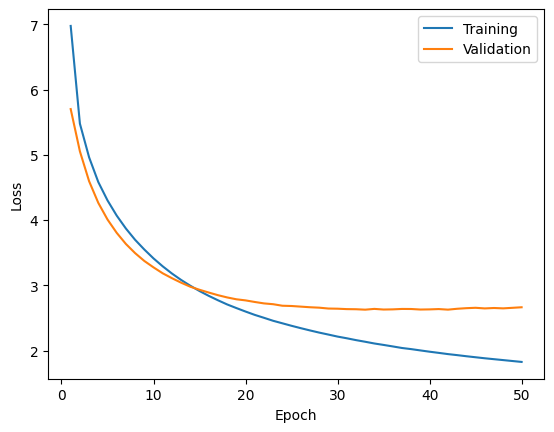

In [48]:
# Plot loss curves
model_state = torch.load('./weights_model_3/tf_model_50.pt')
loss_df = pd.DataFrame(model_state['losses'])
plt.plot(loss_df['epoch']+1, loss_df['train_loss'])
plt.plot(loss_df['epoch']+1, loss_df['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training", "Validation"], loc="upper right")

**Model 4**:\
d_model=512, d_ff=512, N=3, dropout=0.1\
batch_size=64, betas=(0.9, 0.98)

In [44]:
# Train
config = get_training_config()
config['batch_size']=64
config['N']=3
config['d_ff']=512
config['model_dir']="weights_model_4"
config['betas']=(0.9, 0.98)
train_model(config)

Using device cuda


Filter:   0%|          | 0/29000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1014 [00:00<?, ? examples/s]

Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45


Epoch 01: 100%|██████████| 454/454 [00:32<00:00, 13.80it/s, train_loss=5.256, val_loss=4.270]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy in a blue, playing soccer, about to kick the ball.']
TARGET: ['Ein Junge in Blau spielt Fußball und ist im Begriff, den Ball zu schießen.']
PREDICTED: Ein Junge Junge in einem . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman and two boys looking at an information station.']
TARGET: ['Eine Frau und zwei Jungen blicken auf einen Informationsstand.']
PREDICTED: Eine Frau und Frau und ein . . . . . .


Epoch 02: 100%|██████████| 454/454 [00:32<00:00, 13.90it/s, train_loss=4.129, val_loss=3.663]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two people are running at the top of a mountain.']
TARGET: ['Zwei Menschen rennen auf dem Gipfel eines Berges.']
PREDICTED: Zwei Personen gehen durch einen . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Kids conversing and learning in class.']
TARGET: ['Kinder einer Schulklasse sprechen miteinander und lernen.']
PREDICTED: Kinder Kinder und stehen in . . . . . . . . . . . . . .


Epoch 03: 100%|██████████| 454/454 [00:31<00:00, 14.63it/s, train_loss=3.678, val_loss=3.353]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Four women dressed up in funny costumes.']
TARGET: ['Vier Frauen haben sich mit lustigen Kostümen verkleidet.']
PREDICTED: Vier Frauen in . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A boy getting his hair buzzed off by another boy.']
TARGET: ['Einem Jungen werden von einem anderen Jungen die Haare abrasiert.']
PREDICTED: Ein Junge Junge von einem anderen anderen . . . . . . . . . . . . . . .


Epoch 04: 100%|██████████| 454/454 [00:31<00:00, 14.52it/s, train_loss=3.378, val_loss=3.117]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three older women in a living room, decorated for Christmas, a "VAIO" notebook is the center of attention.']
TARGET: ['Drei ältere Frauen in einem weihnachtlich geschmückten Wohnzimmer, im Zentrum der Aufmerksamkeit steht ein VAIO-Notebook.']
PREDICTED: Drei ältere Frauen Frauen in einem Raum , , , , , der . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man with glasses and a little girl with a life jacket swimming in a pool.']
TARGET: ['Ein Mann mit Brille und ein kleines Mädchen mit einer Schwimmweste schwimmen in einem Pool.']
PREDICTED: Ein Mann mit Brille und mit Brille ein kleines Mädchen in einem Schwimmbecken in einem Schwimmbecken . . . . . . . . . . . .


Epoch 05: 100%|██████████| 454/454 [00:33<00:00, 13.63it/s, train_loss=3.148, val_loss=2.964]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young man in a green sweatshirt reads a newspaper on the beach.']
TARGET: ['Ein junger Mann in einem grünen Sweatshirt liest eine Zeitung am Strand.']
PREDICTED: Ein junger Mann in einem grünen Pullover liest liest Zeitung am Strand . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Man with Mardi Gras Beads around his neck holding pole with banner']
TARGET: ['Mann mit Mardi-Gras-Perlen um den Hals trägt Stange mit Banner']
PREDICTED: Ein Mann mit um seinen um mit mit der . . . . . . . . .


Epoch 06: 100%|██████████| 454/454 [00:32<00:00, 13.79it/s, train_loss=2.963, val_loss=2.830]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a red dress with red-hair standing before a bright, multicolored home.']
TARGET: ['Eine Frau mit einem roten Kleid und rotem Haar steht vor einem leuchtend bunten Haus.']
PREDICTED: Eine Frau in einem roten Kleid mit roten Haaren vor einem . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two boys in a tent smile for the camera.']
TARGET: ['Zwei Jungen in einem Zelt lächeln für die Kamera.']
PREDICTED: Zwei Jungen Jungen in einem Zelt lächeln in die Kamera . . . . . . . . . . . .


Epoch 07: 100%|██████████| 454/454 [00:32<00:00, 13.89it/s, train_loss=2.815, val_loss=2.746]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Heavyset woman blowing her hair with a hair dryer smiling all happy']
TARGET: ['Eine korpulente Frau trocknet ihr Haar mit einem Föhn und lächelt dabei glücklich']
PREDICTED: Eine Frau ihre ihre Haar mit einem Haar lächelt . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a restaurant is drinking out of a coconut, using a straw.']
TARGET: ['Eine Frau in einem Restaurant trinkt mit einem Strohhalm aus einer Kokosnuss.']
PREDICTED: Eine Frau in einem Restaurant Restaurant trinkt aus einem . . . . . . . . .


Epoch 08: 100%|██████████| 454/454 [00:33<00:00, 13.37it/s, train_loss=2.694, val_loss=2.693]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Swimmers stand on various levels of a large diving board complex in a room with figures from mythology painted on the wall.']
TARGET: ['Schwimmer stehen auf den verschiedenen Stufen eines großen Sprungturms in einem Raum, dessen Wände mit Figuren aus der Mythologie bemalt sind.']
PREDICTED: Tänzer stehen auf verschiedene in einem großen , springt in einem Raum , und mit einer an der Wand . an der Wand . . . an der Wand . an der Wand sind . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a white shirt is sitting on a crate.']
TARGET: ['Ein Mann in einem weißen T-Shirt sitzt auf einer Kiste.']
PREDICTED: Ein Mann in weißem Hemd sitzt auf einer . . . . . . . . . . . . . .


Epoch 09: 100%|██████████| 454/454 [00:33<00:00, 13.69it/s, train_loss=2.592, val_loss=2.650]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A toddler in a denim hats plays in a tire.']
TARGET: ['Ein kleines Kind mit Jeanshut spielt in einem Reifen.']
PREDICTED: Ein Kleinkind in Jeans und Hüten spielt in einem Reifen . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['4 kids sit on a ledge and converse.']
TARGET: ['Vier Kinder sitzen auf einem Vorsprung und unterhalten sich.']
PREDICTED: Vier Kinder sitzen auf einem und unterhalten sich . . . . . . . . . . . .


Epoch 10: 100%|██████████| 454/454 [00:33<00:00, 13.68it/s, train_loss=2.503, val_loss=2.603]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A room full of sitting and standing adults and children, and eight pink and black balloons hanging from the ceiling.']
TARGET: ['Ein Raum voll mit sitzenden und stehenden Erwachsenen und Kindern, in dem acht pinkfarbene und schwarze Luftballons von der Decke hängen.']
PREDICTED: Ein Raum voller und Erwachsene und Erwachsene , Kinder und schwarze und schwarze , die Decke , die Decke , die Decke und eine Decke . Decke . . lächeln . Decke . sind . Decke . Decke .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A little girl donates to the Salvation Army near a storefront with white, plastic containers.']
TARGET: ['Ein kleines Mädchen spendet an einer Ladenfront mit weißen Plastikbehältern für die Heilsarmee.']
PREDICTED: Ein kleines Mädchen , das in der in der Nähe einer mit wei

Epoch 11: 100%|██████████| 454/454 [00:33<00:00, 13.69it/s, train_loss=2.424, val_loss=2.572]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The lady wearing a black hat is taking a picture while the snowfalls.']
TARGET: ['Die Frau mit einem schwarzen Hut macht ein Foto bei Schneefall.']
PREDICTED: Die Dame mit schwarzem Hut macht ein Foto macht ein Foto . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two boys in a tent smile for the camera.']
TARGET: ['Zwei Jungen in einem Zelt lächeln für die Kamera.']
PREDICTED: Zwei Jungen in einem Zelt lächeln für die Kamera . . . . . . . . . .


Epoch 12: 100%|██████████| 454/454 [00:31<00:00, 14.46it/s, train_loss=2.357, val_loss=2.568]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A baby in a bouncy seat and a standing boy surrounded by toys.']
TARGET: ['Ein Baby in einer Wippe und ein stehender Junge, die von Spielzeug umgeben sind.']
PREDICTED: Ein Baby in einer und ein umgeben von Spielzeug . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['There are construction workers working hard on a project.']
TARGET: ['Bauarbeiter arbeiten hart an einem Bauvorhaben.']
PREDICTED: Bauarbeiter Bauarbeiter arbeiten an einem Projekt . . . . . . . .


Epoch 13: 100%|██████████| 454/454 [00:33<00:00, 13.46it/s, train_loss=2.295, val_loss=2.554]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A small Asian girl runs into focus down a brick street.']
TARGET: ['Ein kleines asiatisches Mädchen rennt entlang einer gepflasterten Straße in den Fokus.']
PREDICTED: Ein kleines asiatisches asiatisches Mädchen läuft eine Backsteinstraße . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A blond-haired woman wearing a blue shirt unwraps a hat.']
TARGET: ['Eine blonde Frau in einem blauen T-Shirt packt eine Mütze aus.']
PREDICTED: Eine blonde Frau in blauem Hemd eine . . . . . . . . .


Epoch 14: 100%|██████████| 454/454 [00:34<00:00, 13.20it/s, train_loss=2.243, val_loss=2.547]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A little girl peering over a blue wall.']
TARGET: ['Ein kleines Mädchen späht über eine blaue Mauer.']
PREDICTED: Ein kleines Mädchen schaut über eine blaue Wand . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a red and white striped shirts sits on a stool at a hotdog stand.']
TARGET: ['Ein Mann in einem rot-weiß gestreiften Hemd sitzt auf einem Hocker an einem Hotdog-Stand.']
PREDICTED: Ein Mann in rot und weiß gestreiften Hemden gestreiften Hemd auf einem einen Teller . . . . . . . . . .


Epoch 15: 100%|██████████| 454/454 [00:33<00:00, 13.38it/s, train_loss=2.190, val_loss=2.531]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A band playing in an outdoor theater, along the river.']
TARGET: ['Eine Band spielt auf einer Freilichtbühne am Fluss.']
PREDICTED: Eine Band spielt in einem im Freien , . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The women is holding the boy while looking across the street.']
TARGET: ['Die Frau hält den Jungen fest, während sie über die Straße blickt.']
PREDICTED: Die Frau hält die einen Jungen und schauen über die Straße . . . . . . . . . .


Epoch 16: 100%|██████████| 454/454 [00:31<00:00, 14.24it/s, train_loss=2.141, val_loss=2.548]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A kid on skating ramp practicing cool moves.']
TARGET: ['Ein Jugendlicher übt coole Moves auf einer Skateboardrampe.']
PREDICTED: Ein Kind Skateboard , das Skateboard , das . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young man is skateboarding on a cement block wall.']
TARGET: ['Ein junger Mann fährt mit dem Skateboard auf einer Betonsteinmauer.']
PREDICTED: Ein junger Mann fährt Skateboard auf einer an einer . . . . . . . . . .


Epoch 17: 100%|██████████| 454/454 [00:34<00:00, 13.24it/s, train_loss=2.101, val_loss=2.536]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People in a produce store picking produce to buy']
TARGET: ['Menschen in einem Laden wählen Produkte zum Kauf aus']
PREDICTED: Menschen in einem Geschäft kaufen kaufen kaufen kaufen . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young woman in "street clothes" and boots by a lake performing a ballet move.']
TARGET: ['Eine junge Frau in „Straßenkleidung“ und Stiefeln führt eine Ballettübung an einem See aus.']
PREDICTED: Eine junge Frau in „ auf der Straße mit Stiefeln und eine . . . . . . . . . .


Epoch 18: 100%|██████████| 454/454 [00:33<00:00, 13.66it/s, train_loss=2.058, val_loss=2.539]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men in red robes performing martial arts.']
TARGET: ['Zwei Männer in roten Gewändern führen eine Kampfsportübung durch.']
PREDICTED: Zwei Männer in roten Gewändern Kampfsport Kampfsport . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People are crossing a tree lined street in front of a building.']
TARGET: ['Menschen überqueren eine baumgesäumte Straße vor einem Gebäude.']
PREDICTED: Leute überqueren eine Straße , an einer von Bäumen Straße . . . . . . . . . . .


Epoch 19: 100%|██████████| 454/454 [00:33<00:00, 13.41it/s, train_loss=2.022, val_loss=2.542]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['An elderly Asian woman is wearing a beret, sunglasses, a yellow scarf, and a plaid jacket.']
TARGET: ['Eine ältere Asiatin trägt eine Baskenmütze, eine Sonnenbrille, einen gelben Schal und eine karierte Jacke.']
PREDICTED: Eine ältere asiatische Frau mit einer Baskenmütze mit Sonnenbrille , Sonnenbrille und eine gelbe Jacke und eine karierten Jacke . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A street performer in an orange jumpsuit rides a tall unicycle as a crowd watches']
TARGET: ['Ein Straßenkünstler in einem orangen Overall fährt auf einem großen Einrad, während eine Menschenmenge zusieht']
PREDICTED: Ein Straßenkünstler Straßenkünstler in orangefarbenem Overall fährt ein hohen Einrad und die Menge beobachtet . beobachtet . beobachtet . . . . .

Epoch 20: 100%|██████████| 454/454 [00:32<00:00, 13.90it/s, train_loss=1.986, val_loss=2.542]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Travelers on a very cold day hiking.']
TARGET: ['Reisende beim Wandern an einem sehr kalten Tag.']
PREDICTED: an einem sehr Tag wandert . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group of people listening to a man talking outside.']
TARGET: ['Eine Gruppe von Menschen hört einem Mann im Freien beim Sprechen zu.']
PREDICTED: Eine Gruppe Leute hört zu einem Mann hört zu . . . . . . . . . . . . . .


Epoch 21: 100%|██████████| 454/454 [00:32<00:00, 13.85it/s, train_loss=1.953, val_loss=2.551]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['4 people trying to fix a bike on a park']
TARGET: ['Vier Menschen versuchen in einem Park, ein Fahrrad zu reparieren']
PREDICTED: 4 Personen versuchen zu reparieren ein Fahrrad auf einem Park . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A single person parachutes through a peaceful sunset.']
TARGET: ['Eine einzelne Person fliegt mit dem Fallschirm durch einen friedvollen Sonnenuntergang.']
PREDICTED: Eine einzelne Person mit Helm schnell Sonnenuntergang durch ein . . . .


Epoch 22: 100%|██████████| 454/454 [00:33<00:00, 13.75it/s, train_loss=1.921, val_loss=2.566]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two young girls dressed in pink pajamas sit on the floor in front of large windows playing house.']
TARGET: ['Zwei kleine Mädchen in rosafarbenen Schlafanzügen sitzen auf dem Boden vor großen Fenstern und spielen Vater-Mutter-Kind.']
PREDICTED: Zwei junge Mädchen in rosa Schlafanzug sitzen auf dem Boden vor großen Fenstern . sehr großen Haus . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two women are walking down the beach carrying boards and flippers.']
TARGET: ['Zwei Frauen gehen den Strand entlang und tragen dabei Bretter und Flossen.']
PREDICTED: Zwei Frauen gehen am Strand entlang und . . . . . . . . .


Epoch 23: 100%|██████████| 454/454 [00:32<00:00, 13.78it/s, train_loss=1.892, val_loss=2.568]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A girl is wearing a large blue and red hat.']
TARGET: ['Ein Mädchen trägt einen großen blau-weißen Hut.']
PREDICTED: Ein Mädchen trägt einen großen blau - roter Mütze . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A closeup of a woman with short red-hair.']
TARGET: ['Die Nahaufnahme einer Frau mit kurzem rotem Haar.']
PREDICTED: Nahaufnahme einer Frau mit kurzen roten Haaren . . . . . . . . . .


Epoch 24: 100%|██████████| 454/454 [00:31<00:00, 14.33it/s, train_loss=1.866, val_loss=2.585]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a domino mask and severe hair is at a party.']
TARGET: ['Eine Frau mit einer Domino-Maske und streng frisiertem Haar auf einer Party.']
PREDICTED: Eine Frau mit Maske auf einer Maske Haaren und Haar . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three white men in t-shirt jump into the air.']
TARGET: ['Drei weiße Männer in T-Shirts springen in die Luft.']
PREDICTED: Drei weiße Männer in T - T - Shirt springt in die Luft . in die Luft . . . . . . . . .


Epoch 25: 100%|██████████| 454/454 [00:34<00:00, 13.16it/s, train_loss=1.841, val_loss=2.594]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['An African-American woman sits at a brown table, wearing a purple dress, pink shoes, and black sunglasses.']
TARGET: ['Eine afroamerikanische Frau sitzt an einem braunen Tisch und trägt ein lilafarbenes Kleid, pinkfarbene Schuhe und eine schwarze Sonnenbrille.']
PREDICTED: Eine afroamerikanische Frau sitzt an einem braunen , rosa trägt ein lila Schuhen , rosa und schwarze Schuhen . . eine schwarze Sonnenbrille . . . . eine schwarze Oberteil . . eine schwarze Frau trägt eine
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A colorful parade led by a man carrying a red flag.']
TARGET: ['Eine farbenfrohe Parade, die von einem Mann angeführt wird, der eine rote Fahne trägt.']
PREDICTED: Ein farbenfroher Umzug von einem Mann , der Parade , der eine rote Flagge trägt eine rote Fahne

Epoch 26: 100%|██████████| 454/454 [00:33<00:00, 13.73it/s, train_loss=1.818, val_loss=2.591]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The car leaves a dust trail as it goes around the dirt track.']
TARGET: ['Das Auto hinterlässt beim Umrunden der Aschenbahn eine Staubwolke.']
PREDICTED: Das Auto Blätter als . um die Erde . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two bicyclists ride down the street past people while talking.']
TARGET: ['Zwei Fahrradfahrer fahren an Menschen vorbei die Straße entlang und unterhalten sich dabei.']
PREDICTED: Zwei Radfahrer fahren auf der Radfahrer fahren an Passanten vorbei und unterhalten sich an . . . . . . . . . . . . .


Epoch 27: 100%|██████████| 454/454 [00:33<00:00, 13.62it/s, train_loss=1.795, val_loss=2.601]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men smoking outside of a park.']
TARGET: ['Zwei Männer rauchen außerhalb eines Parks.']
PREDICTED: Zwei Männer raucht außerhalb eines Park raucht . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Several performers dressed in white clothing and maroon hats are lined up facing each other.']
TARGET: ['Mehrere weiß gekleidete Darsteller mit kastanienbraunen Kappen stehen einander in Reihen gegenüber.']
PREDICTED: Mehrere weiß gekleideter Künstler - - stehen von einander gegenüber sich die einander . . . . . . . . . . . . .


Epoch 28: 100%|██████████| 454/454 [00:32<00:00, 14.00it/s, train_loss=1.774, val_loss=2.629]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three dogs are playing in the water.']
TARGET: ['Drei Hunde spielen im Wasser.']
PREDICTED: Drei Hunde spielen im Wasser . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a restaurant is drinking out of a coconut, using a straw.']
TARGET: ['Eine Frau in einem Restaurant trinkt mit einem Strohhalm aus einer Kokosnuss.']
PREDICTED: Eine Frau in einem Restaurant trinkt aus einer . . . . . . . . . . . . .


Epoch 29: 100%|██████████| 454/454 [00:31<00:00, 14.51it/s, train_loss=1.754, val_loss=2.620]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The men fight during the game.']
TARGET: ['Die Männer kämpfen während des Spiels.']
PREDICTED: Die Männer kämpfen während des Spiels . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two watercrafts, one red and one white, are making a big splash in the water.']
TARGET: ['Zwei Wasserfahrzeuge, von denen eines rot und das andere weiß ist, wirbeln eine Menge Spritzwasser auf.']
PREDICTED: Zwei , ein rot und ein weiß , machen Wasser springt Wasser ins Wasser . Wasser . Wasser . . . . .


Epoch 30: 100%|██████████| 454/454 [00:33<00:00, 13.37it/s, train_loss=1.735, val_loss=2.633]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men in black clothes with blue and red bowties are performing in front of a crowd.']
TARGET: ['Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf.']
PREDICTED: Zwei Männer in schwarzer Kleidung mit blauen und roten Fliegen treten vor einer Menschenmenge führt . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three men stand around a cart near some motorcycles.']
TARGET: ['Drei Männer stehen in der Nähe einiger Motorräder um einen Wagen.']
PREDICTED: Drei Männer stehen um einen Karren in der Nähe von Motorrädern herum . . . . . . . . . . . .


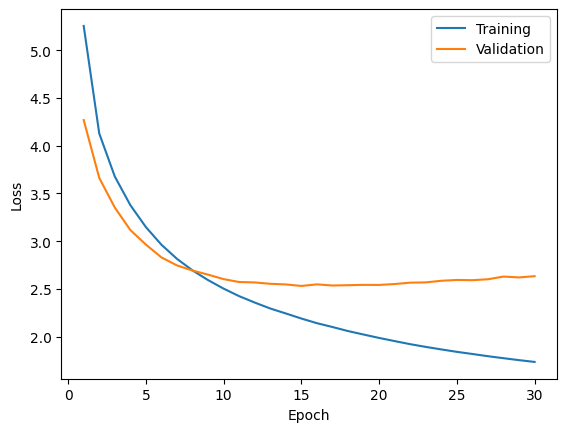

In [48]:
# Plot loss curves
model_state = torch.load('./weights_model_4/tf_model_30.pt')
loss_df = pd.DataFrame(model_state['losses'])
plt.plot(loss_df['epoch']+1, loss_df['train_loss'])
plt.plot(loss_df['epoch']+1, loss_df['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training", "Validation"], loc="upper right")

**Model 5**:\
d_model=512, d_ff=512, N=3, dropout=0.2\
dropout=0.2, batch_size=32, betas=(0.9, 0.98)

In [49]:
# Train 20 epochs
config = get_training_config()
config['batch_size']=32
config['num_epochs']=20
config['N']=3
config['d_ff']=512
config['dropout']=0.2
config['model_dir']="weights_model_5"
config['betas'] = (0.9, 0.98)
train_model(config)

Using device cuda
Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45


Epoch 01: 100%|██████████| 907/907 [00:46<00:00, 19.65it/s, train_loss=5.085, val_loss=4.181]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman and a child sit together in a door frame along a gray sidewalk, as a man and two women walk past.']
TARGET: ['Eine Frau und ein Kind sitzen zusammen in einem Türrahmen an einem grauen Gehweg, während ein Mann und zwei Frauen vorbeigehen.']
PREDICTED: Eine Frau und Frau eine Frau in ein Mann in ein Mann in ein Mann in ein Mann in einem Mann und ein Mann , während ein Mann , während ein Mann , während ein Mann , während ein Mann , während ein Mann , während ein Mann und
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two women in blue suits are sitting on the cement outdoors with concrete and long shaped glass windows behind them.']
TARGET: ['Zwei Frauen in blauen Anzügen sitzen draußen auf dem Beton, während sich hinter ihnen Beton und längliche Glasfenster befinden.']

Epoch 02: 100%|██████████| 907/907 [00:48<00:00, 18.54it/s, train_loss=4.107, val_loss=3.634]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Several people are enjoying a cigarette near an ashtray.']
TARGET: ['Mehrere Menschen genießen eine Zigarette bei einem Aschenbecher.']
PREDICTED: Mehrere Personen Personen sich in eine in einer in der Nähe eines . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The brown dog is wearing a black collar.']
TARGET: ['Der braune Hund trägt ein schwarzes Halsband.']
PREDICTED: Der Hund Hund mit einem schwarzen schwarzen schwarzen . . . . . . . . . . .


Epoch 03: 100%|██████████| 907/907 [00:49<00:00, 18.32it/s, train_loss=3.702, val_loss=3.326]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People are walking down a sidewalk where there is an outdoors market.']
TARGET: ['Menschen gehen auf einem Gehweg, an dem ein Freiluftmarkt stattfindet.']
PREDICTED: Menschen gehen gehen einen Bürgersteig auf einem Gehweg . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a harness climbing a rock wall']
TARGET: ['Ein Mann in einem Klettergurt klettert an einer Felswand']
PREDICTED: Ein Mann in einem mit Helm fährt eine Wand . . . . . . . .


Epoch 04: 100%|██████████| 907/907 [00:47<00:00, 18.95it/s, train_loss=3.427, val_loss=3.121]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two middle-aged men in a room with music equipment speak with each other.']
TARGET: ['Zwei Männer mittleren Alters unterhalten sich miteinander in einem Raum mit Musikausrüstung.']
PREDICTED: Zwei Männer mittleren Alters mittleren Alters mit mit miteinander miteinander . . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A crew of cycling member getting ready for a race.']
TARGET: ['Die Mitglieder einer Radsport-Mannschaft machen sich für ein Rennen bereit.']
PREDICTED: Eine sich vor . . . . . . . . . . . . .


Epoch 05: 100%|██████████| 907/907 [00:49<00:00, 18.23it/s, train_loss=3.224, val_loss=2.972]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A white fluffy dog is jumping and catching a toy.']
TARGET: ['Ein flauschiger weißer Hund springt hoch und fängt ein Spielzeug.']
PREDICTED: Ein weißer weißer Hund springt und springt . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man drives an old-fashioned red race car.']
TARGET: ['Ein Mann fährt ein altmodisches rotes Rennauto.']
PREDICTED: Ein Mann fährt auf einem alten Auto Rennen . . . . . . . . . . . . . . . . . .


Epoch 06: 100%|██████████| 907/907 [00:50<00:00, 18.08it/s, train_loss=3.069, val_loss=2.868]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A red plane flying over a boat as it trails pink smoke.']
TARGET: ['Ein rotes Flugzeug fliegt über einem Boot und zieht dabei pinkfarbenen Rauch hinter sich her.']
PREDICTED: Ein rotes fliegt über ein Boot über ein Boot . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The small brown dog is amidst the potted plants and fallen leaves.']
TARGET: ['Der kleine braune Hund befindet sich inmitten der Topfpflanzen und heruntergefallenen Blätter.']
PREDICTED: Der kleine braune Hund im . . . . . . . . . . . . . .


Epoch 07: 100%|██████████| 907/907 [00:50<00:00, 18.14it/s, train_loss=2.946, val_loss=2.793]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A small dog jumping on a street.']
TARGET: ['Ein kleiner Hund springt auf einer Straße.']
PREDICTED: Ein kleiner Hund springt auf einer Straße . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A tractor is moving dirt to help build up a retaining wall.']
TARGET: ['Ein Traktor bewegt Erde für den Bau einer Stützmauer.']
PREDICTED: Ein Traktor Traktor um sich um zu . . . . . . . . .


Epoch 08: 100%|██████████| 907/907 [00:45<00:00, 20.04it/s, train_loss=2.849, val_loss=2.739]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man picks up a dripping wet woman happily.']
TARGET: ['Ein fröhlicher Mann hebt eine tropfnasse Frau hoch.']
PREDICTED: Ein Mann hebt einen . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A football player in red and white is talking to a coach.']
TARGET: ['Ein rot-weiß gekleideter Footballspieler spricht mit einem Trainer.']
PREDICTED: Ein Football - Spieler in rot - weiß - weißer spricht . spricht . . . . . . . . . . . . . .


Epoch 09: 100%|██████████| 907/907 [00:48<00:00, 18.63it/s, train_loss=2.767, val_loss=2.694]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man in a black and white striped shirt photographing a woman by a fountain.']
TARGET: ['Ein Mann in einem schwarz-weiß gestreiften T-Shirt fotografiert eine Frau an einem Springbrunnen.']
PREDICTED: Ein Mann in schwarz - weiß gestreiften Hemd fotografiert eine Frau bei einem Springbrunnen . . . . . . . . . . eine Frau . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in a blue shirt is riding a bicycle.']
TARGET: ['Eine Frau in einem blauen Hemd fährt auf einem Fahrrad.']
PREDICTED: Eine Frau in blauem Hemd fährt Fahrrad . . . . . . . . . . . . . . . . .


Epoch 10: 100%|██████████| 907/907 [00:47<00:00, 18.99it/s, train_loss=2.697, val_loss=2.672]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A dog walking through a small stream with a rag in his mouth.']
TARGET: ['Ein Hund geht mit einem Tuch im Maul durch einen kleinen Bach.']
PREDICTED: Ein Hund läuft durch einen kleinen Bach mit einem kleinen im Maul . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man wearing glasses at the microphone is looking down at some paper in his hand.']
TARGET: ['Ein Mann mit Brille am Mikrofon blickt auf irgendein Schriftstück hinunter.']
PREDICTED: Ein Mann mit Brille in der Brille blickt in der Hand in der Hand . in der Hand . . . . . . . . . . .


Epoch 11: 100%|██████████| 907/907 [00:50<00:00, 17.94it/s, train_loss=2.639, val_loss=2.633]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two emergency response workers are putting blocks underneath a train.']
TARGET: ['Zwei Mitarbeiter des Notfallschutzes legen Klötze unter einen Zug.']
PREDICTED: Zwei Arbeiter unter einen Zug . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man dressed in brown holding a light saber.']
TARGET: ['Ein braun gekleideter Mann hält ein Lichtschwert.']
PREDICTED: Ein Mann in brauner , braun hält einen . . . . . . . . .


Epoch 12: 100%|██████████| 907/907 [00:45<00:00, 20.08it/s, train_loss=2.586, val_loss=2.623]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A young girl walking along side a small creek']
TARGET: ['Ein kleines Mädchen geht an einem kleinen Bach entlang']
PREDICTED: Ein junges Mädchen geht an einem kleinen Bach . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A elderly white-haired woman is looking inside her register and looking through her glasses.']
TARGET: ['Eine ältere weißhaarige Frau sieht in ihre Kasse und blickt durch ihre Brillengläser hindurch.']
PREDICTED: Eine ältere Frau mit weißem Haar schaut durch ihre Brille und schaut durch ihre Brille . . . . . . . . . . . . . . .


Epoch 13: 100%|██████████| 907/907 [00:49<00:00, 18.35it/s, train_loss=2.539, val_loss=2.600]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman standing on a high cliff on one leg looking over a river.']
TARGET: ['Eine Frau steht auf einem Bein auf einer hohen Klippe und blickt über einen Fluss.']
PREDICTED: Eine Frau steht auf einer hohen Klippe auf einem Bein blickt über einen Fluss . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two children playing on a jungle gym.']
TARGET: ['Zwei Kinder spielen auf einem Klettergerüst.']
PREDICTED: Zwei Kinder spielen auf einem Klettergerüst . . . . . . . . . . .


Epoch 14: 100%|██████████| 907/907 [00:48<00:00, 18.75it/s, train_loss=2.495, val_loss=2.597]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A person with long blue hair standing behind a large crowd of people.']
TARGET: ['Eine Person mit langem blauen Haar steht hinter einer großen Menschenmenge.']
PREDICTED: Eine Person mit langen blauen Haaren steht hinter einer großen Menschenmenge . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two teams, one in pink and one in white, play lacrosse on a field.']
TARGET: ['Zwei Teams, eines davon in Pink und eines in Weiß, spielen Lacrosse auf einem Sportplatz.']
PREDICTED: Zwei Mannschaften , einer in rosa und ein weiß spielen Lacrosse spielen Lacrosse . . . . . . . . . . . . .


Epoch 15: 100%|██████████| 907/907 [00:49<00:00, 18.35it/s, train_loss=2.458, val_loss=2.581]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A singer performing along with the crowd.']
TARGET: ['Ein Sänger singt zusammen mit dem Publikum bei einem Auftritt.']
PREDICTED: Ein Sänger tritt auf einer Menschenmenge mit der Menschenmenge . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The boy leaps of his bed with a karate kick.']
TARGET: ['Der Junge springt mit einem Karatetritt aus dem Bett.']
PREDICTED: Der Junge springt mit einem Bett mit einem . . . . . . . . . . . . .


Epoch 16: 100%|██████████| 907/907 [00:49<00:00, 18.26it/s, train_loss=2.422, val_loss=2.576]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group of people running a charity marathon.']
TARGET: ['Eine Gruppe von Menschen läuft bei einem Wohltätigkeitsmarathon.']
PREDICTED: Eine Gruppe von Menschen laufen einen Marathon . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group of young Asian men walking in a marathon.']
TARGET: ['Eine Gruppe junger asiatischer Männer läuft bei einem Marathon.']
PREDICTED: Eine Gruppe junger asiatischer Männer geht bei einem Marathon . . . . . . . . . . . . .


Epoch 17: 100%|██████████| 907/907 [00:50<00:00, 18.07it/s, train_loss=2.388, val_loss=2.568]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Several people standing on a subway platform.']
TARGET: ['Einige Menschen stehen auf einem U-Bahnsteig.']
PREDICTED: Mehrere Menschen stehen auf einer U - Bahnsteig . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A dog jumps for a yellow and black ball.']
TARGET: ['Ein Hund springt einem gelb-schwarzen Ball hinterher.']
PREDICTED: Ein Hund springt um einen gelb - schwarzen Ball . . . . . . . . .


Epoch 18: 100%|██████████| 907/907 [00:50<00:00, 18.03it/s, train_loss=2.359, val_loss=2.568]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['The women is holding the boy while looking across the street.']
TARGET: ['Die Frau hält den Jungen fest, während sie über die Straße blickt.']
PREDICTED: Die Frau hält die Junge hält die Straße und blickt über die Straße . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ["A man playing Mike Tyson's Punchout on his computer."]
TARGET: ["Ein Mann spielt Mike Tyson's Punch-Out auf seinem Computer."]
PREDICTED: Ein Mann spielt am Computer . am Computer . . . . . . . . .


Epoch 19: 100%|██████████| 907/907 [00:50<00:00, 17.96it/s, train_loss=2.329, val_loss=2.561]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A group of people eating at a restaurant.']
TARGET: ['Eine Gruppe von Menschen isst in einem Restaurant.']
PREDICTED: Eine Gruppe von Menschen essen in einem Restaurant . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Three white men in t-shirt jump into the air.']
TARGET: ['Drei weiße Männer in T-Shirts springen in die Luft.']
PREDICTED: Drei weiße Männer in T - T - T - Shirt springt in die Luft . . . . . . . . . . . . . . . . .


Epoch 20: 100%|██████████| 907/907 [00:50<00:00, 18.08it/s, train_loss=2.301, val_loss=2.573]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A large group of people watching a performer on a stage.']
TARGET: ['Eine große Gruppe von Menschen sieht einem Künstler auf einer Bühne zu.']
PREDICTED: Eine große Gruppe Leute beobachtet einen Künstler auf der Bühne . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['People on the street at a block party.']
TARGET: ['Menschen auf der Straße bei einem Straßenfest.']
PREDICTED: Leute auf der Straße auf einer . . . . . . . . . .


In [51]:
# Train 10 more epochs
config = get_training_config()
config['batch_size']=32
config['num_epochs']=30
config['preload']=20
config['N']=3
config['d_ff']=512
config['dropout']=0.2
config['model_dir']="weights_model_5"
config['betas'] = (0.9, 0.98)
train_model(config)

Using device cuda
Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45
Loading model from ./weights_model_5/tf_model_20.pt


Epoch 21: 100%|██████████| 907/907 [00:49<00:00, 18.25it/s, train_loss=2.276, val_loss=2.564]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman talks to a young girl over a counter.']
TARGET: ['Eine Frau spricht über eine Theke hinweg mit einem kleinen Mädchen.']
PREDICTED: Eine Frau spricht mit einem jungen Mädchen über eine Theke . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two men are out on a bright, sunny day attempting to catch some fish on the lake.']
TARGET: ['Zwei Männer sind an einem hellen, sonnigen Tag unterwegs, um ein paar Fische im See zu fangen.']
PREDICTED: Zwei Männer sind an einem hellen sonnigen Tag versucht , sonnigen See um einen Fisch zu fangen . zu fangen . . . . . . . . . . . zu fangen .


Epoch 22: 100%|██████████| 907/907 [00:51<00:00, 17.57it/s, train_loss=2.252, val_loss=2.567]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two people play water volleyball in a pool.']
TARGET: ['Zwei Menschen spielen Wasservolleyball in einem Pool.']
PREDICTED: Zwei Personen spielen Volleyball in einem Schwimmbecken . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A bearded man in a heavy jacket sits in a corner with a paper cup.']
TARGET: ['Ein bärtiger Mann in einer dicken Jacke sitzt mit einem Pappbecher in einer Ecke.']
PREDICTED: Ein bärtiger Mann in einer großen Jacke sitzt in einer Ecke mit einer . . . . . . . . . . . . .


Epoch 23: 100%|██████████| 907/907 [00:50<00:00, 17.89it/s, train_loss=2.230, val_loss=2.560]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A black dog is jumping over a multicolored barrier.']
TARGET: ['Ein schwarzer Hund springt über ein mehrfarbiges Hindernis.']
PREDICTED: Ein schwarzer Hund springt über eine bunten Feld . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man wakeboards in the water.']
TARGET: ['Ein Mann beim Wakeboarden im Wasser.']
PREDICTED: Ein Mann im Wasser . . . . . . . . . . . .


Epoch 24: 100%|██████████| 907/907 [00:49<00:00, 18.19it/s, train_loss=2.208, val_loss=2.572]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two people walking across a street.']
TARGET: ['Zwei Menschen überqueren eine Straße.']
PREDICTED: Zwei Personen gehen über eine Straße . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A man off in the distance by a Buddhist temple.']
TARGET: ['Ein Mann in der Ferne bei einem buddhistischen Tempel.']
PREDICTED: Ein Mann von einem in der Ferne . . . . . . . . . . . .


Epoch 25: 100%|██████████| 907/907 [00:49<00:00, 18.47it/s, train_loss=2.189, val_loss=2.578]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A white woman and black man walking down the street.']
TARGET: ['Eine weiße Frau und ein schwarzer Mann gehen eine Straße entlang.']
PREDICTED: Eine weiße Frau und ein schwarzer Mann gehen die Straße entlang . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman talks to a young girl over a counter.']
TARGET: ['Eine Frau spricht über eine Theke hinweg mit einem kleinen Mädchen.']
PREDICTED: Eine Frau spricht mit einem jungen Mädchen über eine Theke . . . . . . . . . . .


Epoch 26: 100%|██████████| 907/907 [00:48<00:00, 18.86it/s, train_loss=2.170, val_loss=2.579]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A soccer team player in a green shirt is running off the field.']
TARGET: ['Ein Fußballspieler in einem grünen Trikot läuft vom Spielfeld.']
PREDICTED: Ein Fußballspieler in einem grünen Oberteil rennt über das Feld . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A baseball player kicks up dirt sliding in front of a catcher.']
TARGET: ['Ein Baseballspieler wirbelt Staub auf, während er vor einem Fänger über den Boden gleitet.']
PREDICTED: Ein Baseballspieler tritt gerade vor einem Fänger rutscht . . . . . . . . . . .


Epoch 27: 100%|██████████| 907/907 [00:49<00:00, 18.22it/s, train_loss=2.150, val_loss=2.587]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A medium sized group of people pose in front of the camera.']
TARGET: ['Eine mittelgroße Gruppe von Menschen posiert vor der Kamera.']
PREDICTED: Eine Gruppe Leute posieren vor der Kamera . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Children chasing the ball in a soccer game.']
TARGET: ['Kinder jagen bei einem Fußballspiel dem Ball hinterher.']
PREDICTED: Kinder jagen bei einem Fußballspiel . . . . . . . . . . .


Epoch 28: 100%|██████████| 907/907 [00:45<00:00, 20.12it/s, train_loss=2.132, val_loss=2.595]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two Asian children, a boy and a girl, are standing on the floor next to a tree.']
TARGET: ['Zwei asiatische Kinder, ein Junge und ein Mädchen, stehen neben einem Baum.']
PREDICTED: Zwei asiatische Kinder , ein Junge und ein Mädchen stehen auf dem Boden neben einem Baum . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A motocross rider is slightly airborne on a competition circuit jump.']
TARGET: ['Ein Motocrossfahrer wird bei einem Sprung auf einer Rennstrecke leicht durch die Luft getragen.']
PREDICTED: Ein Motocross - Fahrer befindet sich nach einem in der Luft . nach vorn . nach . nach . . . . . . . . . .


Epoch 29: 100%|██████████| 907/907 [00:46<00:00, 19.56it/s, train_loss=2.115, val_loss=2.610]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A woman in black pants is looking at her cellphone.']
TARGET: ['Eine Frau in schwarzen Hosen blickt auf ihr Handy.']
PREDICTED: Eine Frau in schwarzen Hosen schaut auf ihr Handy . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['Two little black boys are playing with plastic bottles and having a lot of fun.']
TARGET: ['Zwei kleine schwarze Jungen spielen mit Plastikflaschen und haben dabei viel Spaß.']
PREDICTED: Zwei kleine schwarze Jungen spielen mit Flaschen und haben Spaß . . . . . . . . . . . . . . . . .


Epoch 30: 100%|██████████| 907/907 [00:50<00:00, 18.07it/s, train_loss=2.099, val_loss=2.615]


------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A person wearing a hat and scarf looks to the right.']
TARGET: ['Eine Person mit Hut und Schal blickt nach rechts.']
PREDICTED: Eine Person mit Hut und Schal blickt nach rechts . . . . . . . . . . .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A scuba diving class taking a picture during class time.']
TARGET: ['Die Teilnehmer eines Gerätetauchkurses machen ein Foto während des Unterrichts.']
PREDICTED: Ein Taucher machen im . . . . . . . . . . . . . . . . . . . .


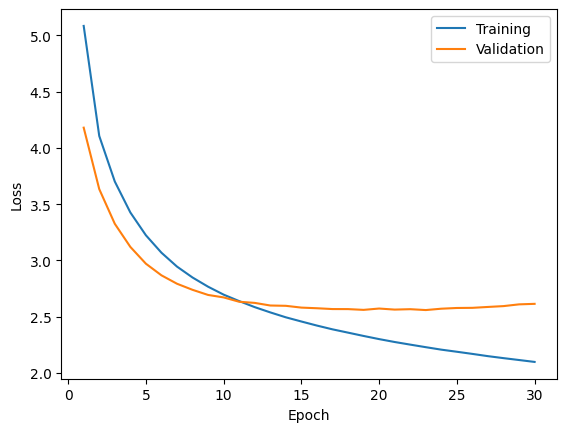

In [52]:
# Plot loss curves
model_state = torch.load('./weights_model_5/tf_model_30.pt')
loss_df = pd.DataFrame(model_state['losses'])
plt.plot(loss_df['epoch']+1, loss_df['train_loss'])
plt.plot(loss_df['epoch']+1, loss_df['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training", "Validation"], loc="upper right")

# Evaluation

In [139]:
# Imports
import pandas as pd
import torch
from torchinfo import summary
from torcheval.metrics.functional.text import bleu_score

### Loss curves

In [52]:
# Load saved model
model_filename = './weights/tf_model_30.pt'
model_state = torch.load(model_filename)
model_state.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'global_step', 'losses'])

In [53]:
# Extract loss data to a dataframe
loss_df = pd.DataFrame(model_state['losses'])

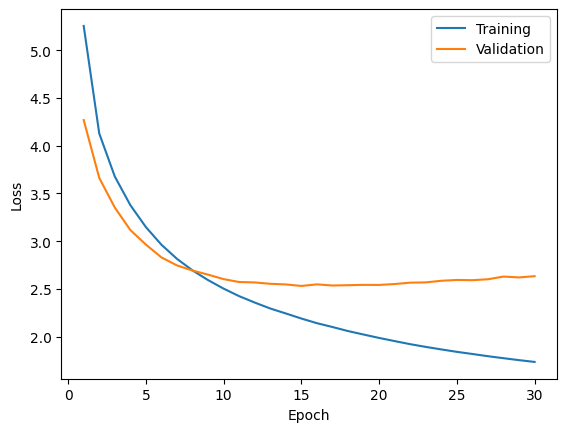

In [56]:
# Plot loss curves
plt.plot(loss_df['epoch']+1, loss_df['train_loss'])
plt.plot(loss_df['epoch']+1, loss_df['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training", "Validation"], loc="upper right")

In [55]:
# Save loss data separately so that we can delete the weights for last epoch
loss_df.to_pickle('./weights/loss.pkl')

### Load best model

In [42]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [43]:
# Load saved model
model_filename = './weights/tf_model_15.pt'
model_state = torch.load(model_filename)
model_state.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'global_step', 'losses'])

In [44]:
# Get config
config = get_training_config()
config['batch_size']=64
config['N']=3
config['d_ff']=512
config['model_dir']="weights_model_4"
config['betas']=(0.9, 0.98)

In [46]:
# Load dataset
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_dataset(dataset_name, config['lang_src'], config['lang_tgt'], config['tokenizer_file'], config['seq_len'], config['batch_size'])

Train set size: 29000
Validation set size: 1014
Max length in source: 41
Max length in target: 45


In [47]:
# Load model
model = build_transformer_model(tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size(), config['seq_len'], config['seq_len'], config['d_model'], N=config['N'], d_ff=config['d_ff']).to(device)
model.load_state_dict(model_state['model_state_dict'])

<All keys matched successfully>

In [95]:
summary(model).trainable_params

24044958

### Evaluate on test set

In [87]:
# Get test dataset
test_ds = get_test_dataset(dataset_name, 'en', 'de', tokenizer_src, tokenizer_tgt, config['seq_len'], 1)

Test set size: 1000
Max length in source: 33
Max length in target: 35


**Sample inference**

In [110]:
# Run inference on test dataset
inputs, lables, preds = run_validation(model, test_ds, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: print(msg), 0, None, num_examples=10, print_output=True)

------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A dark-haired bearded man in glasses and a Hawaiian shirt is sitting on the grass.']
TARGET: ['Ein dunkelhaariger Mann mit Bart, Brille und Hawaiihemd sitzt auf dem Gras.']
PREDICTED: Ein dunkelhaariger Mann mit Bart mit Brille und einem Hemd und ein sitzt .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A table full of pictures in frames, at an outdoor market.']
TARGET: ['Ein Tisch voller gerahmter Bilder, ein Freiluftmarkt.']
PREDICTED: Ein Tisch voller Bilder voller auf einem Markt .
------------------------------------------------------------------------------------------------------------------------
SOURCE: ['A tan dog playing with a stick on the shore.']
TARGET: ['Ein brauner Hund spielt am Ufer mit einem Stock.']
PREDICTED: Ein hellbrauner Hund , spielt mit einem Sto

**Loss**

In [88]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id(SPECIAL_TOKENS[PAD_IDX]), label_smoothing=0.1).to(device)

In [89]:
# Caluclate loss
test_loss = get_val_loss(model, test_ds, tokenizer_src, tokenizer_tgt, config['seq_len'], device, loss_fn)

In [91]:
# Print test loss
print(f'Test loss: {test_loss}')

Test loss: 2.5699050316810608


**BLEU Score**

In [124]:
# Get preds for the whole test set
inputs, lables, preds = run_validation(model, test_ds, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: print(msg), 0, None, num_examples=-1, print_output=False)

In [136]:
# Calculate BLEU scores
bleu_scores = []
for n in range(1,5):
    bleu_scores.append({
        'n_gram': n,
        'score': bleu_score(preds, lables, n_gram=n).item()
    })
bleu_scores_df = pd.DataFrame(bleu_scores)
bleu_scores_df

,n_gram,score
0,1,0.498014
1,2,0.387071
2,3,0.299001
3,4,0.229406


In [138]:
# Print scores for markdown
print(bleu_scores_df.to_markdown())

|    |   n_gram |    score |
|---:|---------:|---------:|
|  0 |        1 | 0.498014 |
|  1 |        2 | 0.387071 |
|  2 |        3 | 0.299001 |
|  3 |        4 | 0.229406 |


### Inference

#### Inference util

In [111]:
# Inference function
def inference(model, input_text, tokenizer_src, tokenizer_tgt, seq_len, max_len, device, stop_tokens=[]):

    # Special tokens
    bos_token = torch.LongTensor([tokenizer_src.token_to_id(SPECIAL_TOKENS[BOS_IDX])])
    eos_token = torch.LongTensor([tokenizer_src.token_to_id(SPECIAL_TOKENS[EOS_IDX])])
    pad_token = torch.LongTensor([tokenizer_src.token_to_id(SPECIAL_TOKENS[PAD_IDX])])
    
    # Generate encoder inputs
    input_tokens = tokenizer_src.encode(input_text).ids
    padding_tokens_count = max_len - len(input_tokens) - 2
    encoder_input = torch.cat([
        bos_token, 
        torch.tensor(input_tokens, dtype=torch.int64), 
        eos_token, 
        torch.full((padding_tokens_count,), pad_token.item(), dtype=torch.int64)
    ]).to(device)
    encoder_mask = (encoder_input != pad_token.item()).unsqueeze(0).unsqueeze(0).int().to(device)  # (1, 1, seq_len): (batch dim, seq dim, mask data)

    # Generate output
    model_output = inference_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
    
    # Decode output and return
    pred_text = tokenizer_tgt.decode(model_output.detach().cpu().numpy())
    return pred_text, model_output

#### Test inference

In [112]:
input_texts

['A man in uniform and a man in a blue shirt are standing in front of a truck.']

In [114]:
input_texts = [
    'Three little boys are walking down the road.',
    'A man in an orange hat starring at something.',
    'A group of people standing in front of an igloo.',
    'Three people sit in a cave.',
    'People standing outside of a building.',
    'Group of Asian boys wait for meat to cook over barbecue.',
    'A man in uniform and a man in a blue shirt are standing in front of a truck.'
]

In [117]:
inferences = []
for txt in input_texts:
    text, tokens = inference(model, txt, tokenizer_src, tokenizer_tgt, config['seq_len'], config['seq_len'], device, stop_tokens=['.'])
    inferences.append(text)

In [119]:
inferences

['Drei kleine Jungen gehen die Straße entlang .',
 'Ein Mann mit orangefarbenem orangefarbener Mütze starrt auf etwas .',
 'Eine Gruppe Leute steht vor einem .',
 'Drei Personen sitzen auf einer .',
 'Leute stehen vor einem Gebäude .',
 'Eine Gruppe asiatischer Jungen warten darauf , der , der , bereitet zu sein zu sein .',
 'Ein Mann in Uniform und ein Mann in blauem Hemd stehen vor einem Lastwagen .']